In [1]:
import gc
import warnings
import pickle
from math import ceil
from tqdm.notebook import tqdm
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import ticker
from matplotlib.gridspec import GridSpec
from matplotlib.axes import Axes
import numpy as np
import seaborn as sns
import pandas as pd
import torch
from torch.nn.utils.rnn import pad_sequence

try:
    import sys

    sys.path.append("D:/ibl/brainnet")
    sys.path.append("E:/Project/myutils")
except Exception:
    raise ImportError("No such directory")
else:
    import lbw
    from utils import (
        mae_function,
        rmse_function,
        mape_function,
        r2_function,
        tensor_to_df,
        tensor_to_np,
        df_to_tensor,
        color_list,
        marker_list,
        ls_list,
        fsize,
        width,
        column_width,
        page_width,
        resize_image,
        get_model_with_state_dict,
        rolling_df,
        resample_df,
        get_model_with_state_dict,
        get_flops,
        get_params_num,
        # compute_sampen,
    )

%matplotlib inline

In [2]:
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)  # 屏蔽FutureWarning

In [3]:
plt.style.use(".vscode/ieee.mplstyle")  # 使用 ieee 风格
# matplotlib.rcParams.update({"text.usetex": False})  # 不使用 TeX
print(matplotlib.rcParams["text.usetex"])

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
np.random.seed(2023)

True


# 画图方法

In [4]:
show_res = True if input("Show results: 0: False, 1: True") == "1" else False
train_done = True if input("Train done: 0: False, 1: True") == "1" else False
figpath = "./figures/"  # 图片路径
tabpath = "./tables/"  # 表格路径

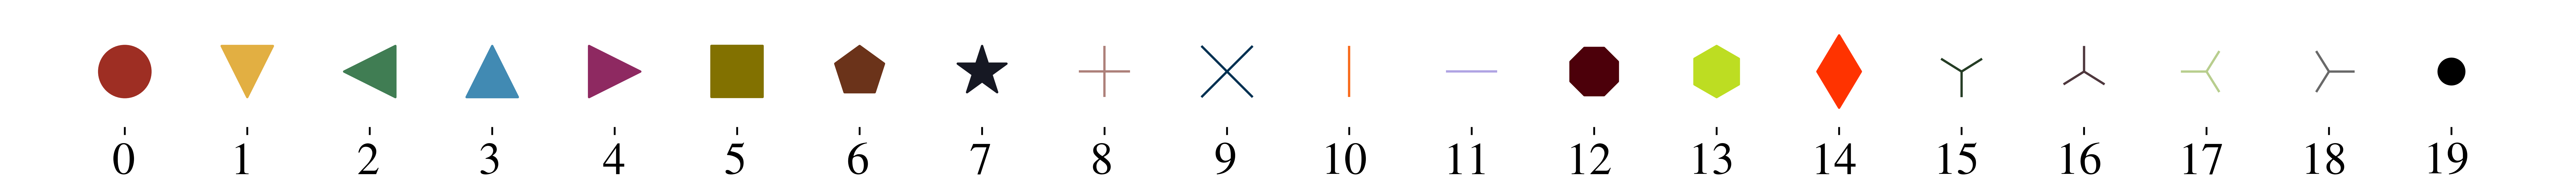

In [5]:
def plot_reference():
    _, ax = plt.subplots(figsize=(width, 1))
    for i in range(len(color_list)):
        ax.scatter(
            x=[i],
            y=[1.0],
            c=color_list[i],
            marker=marker_list[i],
            s=500,
        )
    ax.spines[:].set_visible(False)
    ax.set_xticks(
        [i for i in range(len(color_list))],
        [str(i) for i in range(len(color_list))],
        fontsize=fsize,
    )
    ax.set_yticks([])

if show_res:
    plot_reference()

# 模型 数据 性能指标

In [6]:
from train_models import load_data
from models import (
    SOCNet,
    IRParamsNet,
    QNet,
    LSTMForSOC,
    TFTForSOC,
    ODERNNForSOC,
    CNNForIR,
    LSTMForIR,
    TFTForIR,
    ODERNNForIR,
    CNNForQ,
    LSTMForQ,
    TFTForQ,
    ODERNNForQ,
    VoltageNet,
)
from degrad import (
    degrad_fit_offline,
    pso_optim_offline,
    degrad_pred_online,
    degrad_fun,
    two_phase_log,
    sigmoidal,
)

In [7]:
all_datasets = {
    "0": "a123",
    "1": "mich",
    # "2": "nasa2014",
    # "3": "everlasting",
}
data_sel = input(
    "Please select data to preprocess:\n"
    + "\n".join([f"{k}: {v}" for k, v in all_datasets.items()])
)
data_selection = all_datasets[data_sel]
Qn = {"0": 1.1, "1": 5.0}[data_sel]
ck_0 = {"0": None, "1": 1000}[data_sel]
ce_0 = {"0": None, "1": 1500}[data_sel]
cells_barcode = {
    "0": [
        "150800460498",
        "150800460608",
        "150800460641",
        "150800460627",
    ],
    "1": [f"{i:02}" for i in range(1, 19)],
}[data_sel]

In [8]:
def plot_dataset(barcode: str, cycle_max=None, cycle_step=None, save=False):
    with open("datasets/a123/cells_data.pkl", "rb") as f:
        dataset: lbw.datasets.TimeSeriesDataset = pickle.load(f)
    samples: list[lbw.samples.TimeSeries] = dataset.select("barcode", barcode)

    fig, axs = plt.subplots(4, 1, figsize=(0.4 * width, 0.45 * width), sharex=True)
    axs: list[Axes] = axs.flatten()

    cycle_max = len(samples) if cycle_max is None else cycle_max
    cycle_step = cycle_max // 15 if cycle_step is None else cycle_step

    for cycle in range(0, cycle_max, cycle_step):
        t = samples[cycle].data["t"]
        axs[0].plot(
            t,
            samples[cycle].data["I"],
            linewidth=2 if cycle == 0 else 1,
            linestyle="-" if cycle == 0 else "-.",
            alpha=1 - cycle / cycle_max,
            color=color_list[0],
        )
        axs[1].plot(
            t,
            samples[cycle].data["T"],
            linewidth=2 if cycle == 0 else 1,
            linestyle="-" if cycle == 0 else "-.",
            alpha=1 - cycle / cycle_max,
            color=color_list[1],
        )
        axs[2].plot(
            t,
            samples[cycle].data["U"],
            linewidth=2 if cycle == 0 else 1,
            linestyle="-" if cycle == 0 else "-.",
            alpha=1 - cycle / cycle_max,
            color=color_list[2],
        )
        axs[3].plot(
            t,
            samples[cycle].data["SOC"],
            linewidth=2 if cycle == 0 else 1,
            linestyle="-" if cycle == 0 else "-.",
            alpha=1 - cycle / cycle_max,
            color=color_list[3],
        )

    def set_ax(i: int, ax: Axes, ylabel: str):
        t_d = samples[0].covariate[
            "t_d"
        ]  # np.asarray(I < 0.99 * np.min(I)).nonzero()[0][10]
        t_D = samples[0].covariate[
            "t_D"
        ]  # np.asarray(I < 0.99 * np.min(I)).nonzero()[0][-10]
        ax.axvline(samples[0].data["t"][t_d], linestyle=":", color=color_list[-2])
        ax.axvline(samples[0].data["t"][t_D], linestyle=":", color=color_list[-2])
        ax.tick_params("both", labelsize=fsize - 4)
        ax.set_ylabel(ylabel, fontsize=fsize - 2)
        ax.yaxis.set_label_coords(-0.05, 0.5)
        if i == 0:
            ax.text(
                (samples[0].data["t"][t_d] + samples[0].data["t"][t_D]) / 2,
                0.9 * max(samples[0].data["I"]),
                r"\(I < 0.99\min I\)",
                fontsize=fsize - 2,
                ha="center",
                va="top",
            )
        if i == 3:
            ax.text(
                (samples[0].data["t"][0] + samples[0].data["t"][t_d]) / 2,
                1,
                "Charge",
                fontsize=fsize - 2,
                ha="right",
                va="top",
            )
            ax.text(
                (samples[0].data["t"][t_d] + samples[0].data["t"][t_D]) / 2,
                1,
                "Discharge",
                fontsize=fsize - 2,
                ha="center",
                va="top",
            )
            ax.yaxis.set_major_formatter(
                ticker.FuncFormatter(lambda x, pos: f"{int(x * 100):2d}")
            )  # 换成百分数
        return True

    [
        set_ax(i, ax, ylabel)
        for i, (ax, ylabel) in enumerate(
            zip(
                axs,
                [
                    r"Current \(I\) (A)",
                    r"Temperature \(T\) (℃)",
                    r"Voltage \(U\) (V)",
                    r"\(SOC\) (\%)",
                ],
            )
        )
    ]
    axs[-1].set_xlabel(r"Time \(t\) (min)", fontsize=fsize - 2)
    fig.tight_layout()
    if save:
        fig.savefig(
            figpath + "dataset.png",
            bbox_inches="tight",
            pad_inches=0.1,
            transparent=True,
        )
        resize_image(figpath + "dataset.png", column_width)

if show_res and data_selection == "a123":
    plot_dataset(cells_barcode[2], save=False)

# 退化模型辨识与预测

## 模型原理图

In [9]:
def plot_degrad_model(barcode: str, save=False):
    # 读取数据
    with open("datasets/a123/cells_data.pkl", "rb") as f:
        dataset: lbw.datasets.TimeSeriesDataset = pickle.load(f)
    samples: list[lbw.samples.TimeSeries] = dataset.select("barcode", barcode)
    # 创建一个图形对象
    fig = plt.figure(figsize=(0.6 * width, 0.25 * width))

    # 创建一个 GridSpec 对象，定义子图的布局：2 行 3 列
    gs = GridSpec(2, 3, width_ratios=[2, 1, 1], height_ratios=[1, 1])
    targets = ["SOH", "f_R", "eta", "SOC_0"]

    for target in targets:
        match target:
            case "SOH":
                theta = np.array([s.covariate["Qd"] / Qn for s in samples])
                i, j = 0, 0
                label = r"\(SOH\)"
            case "f_R":
                theta = np.array(
                    [
                        (2 * samples[0].covariate["IR"] - s.covariate["IR"])
                        / samples[0].covariate["IR"]
                        for s in samples
                    ]
                )
                i, j = 0, 1
                label = r"\(f_{R}\)"
            case "eta":
                theta = np.array([s.covariate["eta_d"] for s in samples])
                i, j = 1, 0
                label = r"\(\eta\)"
            case _:
                theta = np.array([s.data["SOC"].iloc[s.covariate["t_d"]] for s in samples])
                i, j = 1, 1
                label = r"\(SOC(t_{0})\) (\%)"
        cycles, theta, theta_pred, params = degrad_fit_offline(theta, target)
        print(f"For {target}, params are: {params}")
        ax = fig.add_subplot(gs[i, j + 1])
        ax.plot(
            cycles[1:],
            theta[1:],
            color=color_list[1],
            linewidth=2,
            linestyle=ls_list[0],
            label="True Value",
            zorder=0,
        )
        ax.plot(
            cycles[1:],
            theta_pred[1:],
            color=color_list[2],
            linewidth=2,
            linestyle=ls_list[1],
            label="Fitted Value",
            zorder=2,
        )
        ax.legend(loc="lower left", fontsize=fsize - 4)
        ax.tick_params(axis="both", labelsize=fsize - 8)
        if target == "SOC_0":
            ax.yaxis.set_major_formatter(
                ticker.FuncFormatter(lambda x, pos: f"{int(x * 100):2d}")
            )
        else:
            ax.yaxis.set_major_formatter(ticker.FormatStrFormatter("%.1f"))
        ax.set_xlabel("Cycle", fontsize=fsize - 4)
        ax.set_ylabel(label, fontsize=fsize - 4)

    # 创建第五个子图
    ax_left = fig.add_subplot(gs[:, 0])
    cycles = np.arange(0, len(samples) + 1)
    ck = 275
    ce = cycles[-1]
    degrad_traj = degrad_fun(cycles, -0.8e-5, 1.0, 2e-2, ck)
    theta_k = degrad_traj[ck]
    theta_e = degrad_traj[-1]
    theta_mid = (1 + theta_e) / 2
    ax_left.set_xlim(0, cycles[-1] + 50)
    ax_left.set_ylim(theta_e - 0.001, 1 + 0.004)
    ax_left.plot(
        cycles[1:],
        degrad_traj[1:],
        color=color_list[2],
        linewidth=4,
        linestyle=ls_list[1],
        label=r"Predicted Trajectory of \(\theta\)",
        zorder=0,
    )
    ax_left.scatter(
        ck,
        theta_k,
        c=color_list[0],
        s=100,
        marker=marker_list[0],
        alpha=0.8,
        # label="Knee Point",
        zorder=3,
    )
    ax_left.annotate(
        "Knee Point",
        (ck, theta_k),
        (ce - 50, (1 + theta_k) / 2),
        fontsize=fsize - 4,
        arrowprops=dict(facecolor="k", arrowstyle="-"),
        ha="center",
        va="top",
    )

    length = 150  # 箭头长度
    offset = 0  # x 方向的偏移量
    # 箭头1的起点和方向
    y1_start = theta_mid + 0.008
    # 箭头2的起点和方向
    y2_start = theta_mid - 0.008
    # 画第一个箭头
    ax_left.annotate(
        "",
        xy=(ck - offset - length, y1_start),
        xytext=(ck - offset, y1_start),
        arrowprops=dict(facecolor=color_list[-2], arrowstyle="fancy", linewidth=1),
        size=20,
        va="center",
        ha="center",
    )
    # 画第二个箭头
    ax_left.annotate(
        "",
        xy=(ck + offset + length, y2_start),
        xytext=(ck + offset, y2_start),
        arrowprops=dict(facecolor=color_list[-2], arrowstyle="fancy", linewidth=1),
        size=20,
        va="center",
        ha="center",
    )
    # ax_left.text(
    #     ck - 5 - offset,
    #     y1_start + 0.001,
    #     r"\(a_1 (c - 1) + b_1\)",
    #     fontsize=fsize - 4,
    #     ha="right",
    #     va="bottom",
    # )
    ax_left.text(
        ck - 5 - offset,
        y1_start + 0.001,
        "Linear",
        fontsize=fsize - 4,
        ha="right",
        va="bottom",
    )
    # ax_left.text(
    #     ck + 5 + offset,
    #     y2_start - 0.001,
    #     r"\(a_2 - a_2 e^{b_2(c - c_k)} + \tilde{\theta}_k\)",
    #     fontsize=fsize - 4,
    #     ha="left",
    #     va="top",
    # )
    ax_left.text(
        ck + 5 + offset,
        y2_start - 0.001,
        "Exponential",
        fontsize=fsize - 4,
        ha="left",
        va="top",
    )

    # 生成一个对数等距的数组
    random_values = np.logspace(0, 1, ck + 1) - 1  # 减去 1 使其从 0 开始
    random_values = (
        theta_e + (theta_mid - theta_e) * random_values / random_values[-1]
    )  # 线性变换到 [theta_e, theta_mid]
    random_values[:-1] = random_values[:-1] - np.random.rand(ck) * 0.001
    ax_left.fill_between(
        cycles[: ck + 1], random_values, -1, color=color_list[1], alpha=0.6
    )
    ax_left.text(
        (1 + ck) / 2,
        theta_mid - 5e-4,
        "Probability for\nExponential Stage",
        fontsize=fsize - 4,
        ha="center",
        va="top",
        # backgroundcolor="w",
    )

    ax_left.plot([ck, ck], [-1, theta_k], color=color_list[-2], linestyle=":")
    ax_left.plot([ce, ce], [-1, theta_e], color=color_list[-2], linestyle=":")
    ax_left.plot([-1, ck], [theta_k, theta_k], color=color_list[-2], linestyle=":")
    ax_left.plot([-1, ck], [theta_mid, theta_mid], color=color_list[-2], linestyle=":")
    ax_left.plot([-1, ce], [theta_e, theta_e], color=color_list[-2], linestyle=":")

    ax_left.set_xticks(
        [ck, ce],
        # [r"\(c_{k\theta}\)", r"\(c_{e\theta}\)"],
        [r"\(c_{k\theta}\)", ""],
        fontsize=fsize - 4,
    )
    ax_left.set_yticks(
        [1.0, theta_mid, theta_k, theta_e],
        ["1", "0.5", r"\(\tilde{\theta}_k\)", r"\(\tilde{\theta}_e\)"],
        fontsize=fsize - 4,
    )
    ax_left.legend(loc="upper right", fontsize=fsize - 4)
    fig.tight_layout()
    if save:
        fig.savefig(
            figpath + "degrad.png",
            bbox_inches="tight",
            pad_inches=0.1,
            transparent=True,
        )
        resize_image(figpath + "degrad.png", page_width)

if show_res and data_selection == "a123":
    plot_degrad_model(cells_barcode[2], save=False)

In [10]:
def plot_knee(save=False):
    from scipy import stats

    fig, ax = plt.subplots(figsize=(0.4 * width, 0.3 * width))

    with open(f"datasets/{data_selection}/cells_data.pkl", "rb") as f:
        dataset: lbw.datasets.TimeSeriesDataset = pickle.load(f)
    samples: list[lbw.samples.TimeSeries] = dataset.select("barcode", cells_barcode[2])

    # 进行参数辨识和在线估计
    theta = np.array([s.covariate["Qd"] / Qn for s in samples])
    cycles, theta, theta_pred, st_param, sq_param = degrad_pred_online(
        theta, "SOH", ck_0=ck_0, ce_0=ce_0
    )
    c_k_0 = st_param["ck_0"]
    c_e_0 = st_param["ce_0"]
    # for barcode in cells_barcode:
    #     cycles, theta, theta_pred, st_param, sq_param = pred_one_cell(barcode)
    # df_pred = pd.DataFrame(
    #     {
    #         "cycle": cycles,
    #         "theta": theta,
    #         "theta_pred": theta_pred,
    #         "epsilon": sq_param["epsilon"],
    #         "epsilon_lb": sq_param["epsilon_lb"],
    #         "epsilon_ub": sq_param["epsilon_ub"],
    #     }
    # )
    # ck = st_param["ck"]
    # df_pred.iloc[ck + 1 - 20 : ck + 1 + 20]
    # print(
    #     df_pred["epsilon"].iloc[ck + 1 - 20 : ck + 1].mean(),
    #     df_pred["epsilon"].iloc[ck + 1 : ck + 1 + 20].mean(),
    # )
    # print(
    #     df_pred["epsilon"].iloc[ck + 1 - 20 : ck + 1].std(),
    #     df_pred["epsilon"].iloc[ck + 1 : ck + 1 + 20].std(),
    # )
    # sns.kdeplot(df_pred["epsilon"].iloc[ck + 1 - 20 : ck + 1], color="g")
    # sns.kdeplot(df_pred["epsilon"].iloc[ck + 1 + 20 :], color="r")

    p_prior = np.interp(cycles, [0, c_k_0, c_e_0], [0.0, 0.5, 1.0])
    pk_0 = p_prior[c_k_0]
    pe_0 = p_prior[-1]
    ax.plot(
        cycles[1:],
        p_prior[1:],
        color=color_list[3],
        linewidth=2,
        linestyle=(0, (3, 1, 1, 1)),
        zorder=0,
    )

    xmargin = 10
    ymargin = 0.01
    ax.plot([-2 * xmargin, ck_0], [pk_0, pk_0], color=color_list[-2], linestyle=":")
    ax.text(cycles[0] + 10, pe_0 - ymargin, "1.0", fontsize=fsize, ha="left", va="top")
    ax.text(cycles[0] + 10, pk_0 - ymargin, "0.5", fontsize=fsize, ha="left", va="top")
    ax.text(
        400,
        p_prior[400],
        "Prior",
        fontsize=fsize,
        ha="right",
        va="bottom",
    )

    # 在主图 ax 中放置一个小的 Axes，称为 ax2
    ax2_left = 0.38
    ax2_bottom = 0.01
    ax2_width = 0.4
    ax2_height = 0.6
    ax2 = ax.inset_axes(
        (ax2_left, ax2_bottom, ax2_width, ax2_height)
    )  # [left, bottom, width, height]

    # 生成数据
    loc_l = 0
    loc_e = -2
    y = np.linspace(-3 + loc_e, 3, 1000)
    linear_pdf = stats.norm.pdf(y, loc=loc_l, scale=0.4)
    exponential_pdf = stats.norm.pdf(y, loc=loc_e, scale=1)

    # 在 ax2 中绘制正态分布的概率密度函数图像
    ax2.plot(linear_pdf, y, color=color_list[1])
    ax2.plot(exponential_pdf, y, color=color_list[4])
    ax2.text(
        linear_pdf.max(), loc_l, "Linear", fontsize=fsize - 2, ha="left", va="center"
    )
    ax2.text(
        exponential_pdf.max(),
        loc_e,
        "Exponential",
        fontsize=fsize - 2,
        ha="left",
        va="center",
    )
    ax2.text(0.3, y.max() - 0.5, "Likelihood", fontsize=fsize - 2, ha="left", va="top")
    # 填充图像和 y 轴之间的空白
    ax2.fill_betweenx(y, linear_pdf, color=color_list[1], alpha=0.3)
    ax2.fill_betweenx(y, exponential_pdf, color=color_list[4], alpha=0.3)

    ax2.set_ylim(y.min(), y.max())
    ax2.set_xticks([])  # 隐藏 X 轴的刻度和刻度标签
    ax2.set_yticks([])
    ax2.spines[["top", "bottom", "right"]].set_visible(False)  # 隐藏 spines

    ax.set_xlim(cycles[0], cycles[-1] + xmargin)
    ax.set_ylim(0, pe_0)
    # ax.axis("off")  # 同时关闭ticks, tick labels, axis labels
    ax.set_xticks([])  # 隐藏 X 轴的刻度和刻度标签
    ax.set_yticks([])  # 隐藏 Y 轴的刻度和刻度标签
    # ax.spines[:].set_visible(False)  # 隐藏 spines
    ax.set_xlabel("Cycle", fontsize=fsize - 2)
    ax.set_ylabel("Probability", fontsize=fsize - 2)
    fig.tight_layout()
    if save:
        fig.savefig(
            figpath + "knee.png",
            bbox_inches="tight",
            pad_inches=0.1,
            transparent=True,
        )
        resize_image(figpath + "knee.png", column_width)


# if show_res and data_selection == "a123":
#     plot_knee(save=False)

## 预测结果图

In [11]:
def plot_pred(barcode: str, targets: list[str] | None = None, save=False):
    from mpl_toolkits.axes_grid1.inset_locator import mark_inset

    # 读取数据
    with open(f"datasets/{data_selection}/cells_data.pkl", "rb") as f:
        dataset: lbw.datasets.TimeSeriesDataset = pickle.load(f)
    samples: list[lbw.samples.TimeSeries] = dataset.select("barcode", barcode)
    if targets is None:
        targets = ["SOH", "f_R", "eta"]

    fig = plt.figure(figsize=(width, 0.3 * width))
    gs = GridSpec(2, 3, figure=fig, height_ratios=[3, 1])
    axes = [fig.add_subplot(gs[0, i]) for i in range(3)]
    axesmargin = [fig.add_subplot(gs[1, i]) for i in range(3)]
    for ax, axm, target in zip(axes, axesmargin, targets):
        match target:
            case "SOH":
                theta = np.array([s.covariate["Qd"] / Qn for s in samples])
                label = "Capacity (Ah)"
                legend_loc = "lower left"
                inset_axes_bounds = (0.15, 0.45, 0.4, 0.3)
                inset_ticks = (True, False, True, False)
                inset_conn_loc = (2, 4)

                def transform(theta: np.ndarray):
                    return theta * Qn

            case "f_R":
                theta = np.array(
                    [
                        (2 * samples[0].covariate["IR"] - s.covariate["IR"])
                        / samples[0].covariate["IR"]
                        for s in samples
                    ]
                )
                label = r"Resistance (\(\Omega\))"
                legend_loc = "upper left"
                inset_axes_bounds = (0.2, 0.25, 0.4, 0.3)
                inset_ticks = (False, True, True, False)
                inset_conn_loc = (1, 3)

                def transform(theta: np.ndarray):
                    return (2 - theta) * samples[0].covariate["IR"]

            case _:
                theta = np.array([s.covariate["eta_d"] for s in samples])
                label = "Efficiency"
                legend_loc = "lower left"
                inset_axes_bounds = (0.2, 0.45, 0.4, 0.3)
                inset_ticks = (True, False, True, False)
                inset_conn_loc = (1, 2)

                def transform(theta: np.ndarray):
                    return theta

        # 进行参数辨识和在线估计
        cycles, theta, theta_pred, st_param, sq_param = degrad_pred_online(
            theta, target, ck_0=ck_0, ce_0=ce_0
        )
        ck = st_param["ck"]
        epsilon_lb = sq_param["epsilon_lb"]
        epsilon_ub = sq_param["epsilon_ub"]
        y = transform(theta)
        y_pred = transform(theta_pred)
        y_lb = transform(theta_pred + epsilon_lb)
        y_ub = transform(theta_pred + epsilon_ub)
        # 结果展示
        ax: plt.Axes
        ax.plot(
            cycles[1:],
            y[1:],
            color=color_list[1],
            linewidth=2,
            linestyle=ls_list[0],
            label="True Value",
            zorder=0,
        )
        ax.plot(
            cycles[1:],
            y_pred[1:],
            color=color_list[2],
            linewidth=2,
            linestyle=ls_list[1],
            label="Prediction",
            zorder=2,
        )
        if ck is not None:
            ax.scatter(
                ck,
                y[ck],
                c=color_list[0],
                s=40,
                alpha=0.6,
                marker=marker_list[0],
                label="Knee Point",
                zorder=3,
            )
        ax.fill_between(
            cycles[1:],
            y_lb[1:],
            y_ub[1:],
            color=color_list[3],
            alpha=0.4,
            label=r"95\% Confidence Interval",
            zorder=-1,
        )
        ax.legend(
            loc=legend_loc,
            fontsize=fsize - 4,
        )
        ax.tick_params("both", labelsize=fsize - 4)
        ax.set_xlabel("Cycle", fontsize=fsize - 2)
        ax.set_ylabel(label, fontsize=fsize - 2)
        if ck is not None:
            axin = ax.inset_axes(inset_axes_bounds)
            axin.plot(
                cycles[1:],
                y[1:],
                color=color_list[1],
                linewidth=5,
                linestyle=ls_list[0],
                zorder=0,
            )
            axin.plot(
                cycles[1:],
                y_pred[1:],
                color=color_list[2],
                linewidth=5,
                linestyle=ls_list[1],
                zorder=2,
            )
            axin.scatter(
                ck,
                y[ck],
                c=color_list[0],
                s=80,
                alpha=0.6,
                marker=marker_list[0],
                zorder=3,
            )
            axin.fill_between(
                cycles[1:],
                y_lb[1:],
                y_ub[1:],
                color=color_list[3],
                alpha=0.4,
                zorder=-1,
            )
            axin.tick_params(
                axis="both",
                labelsize=fsize - 6,
                labelbottom=inset_ticks[0],
                bottom=inset_ticks[0],
                labeltop=inset_ticks[1],
                top=inset_ticks[1],
                labelleft=inset_ticks[2],
                left=inset_ticks[2],
                labelright=inset_ticks[3],
                right=inset_ticks[3],
            )
            zone_left = ck - 20  # 放大区域的左端
            zone_right = ck + 20  # 放大区域的右端
            axin.set_xlim(zone_left, zone_right)
            y_all = np.hstack(
                (
                    y[zone_left:zone_right],
                    y_pred[zone_left:zone_right],
                    y_lb[zone_left:zone_right],
                    y_ub[zone_left:zone_right],
                )
            )
            y_min = np.min(y_all)
            y_max = np.max(y_all)
            axin.set_ylim(y_min, y_max)  # 对应Y边界
            mark_inset(
                ax, axin, loc1=inset_conn_loc[0], loc2=inset_conn_loc[1], lw=1, zorder=4
            )

        error = (theta[1:] - theta_pred[1:]) / theta[1:]
        lim = 0.01
        axm.fill_between(
            cycles[1:],
            error,
            color=color_list[0],
            where=error > 0,
            interpolate=True,
            alpha=0.5,
        )
        axm.fill_between(
            cycles[1:],
            error,
            color=color_list[-1],
            where=error <= 0,
            interpolate=True,
            alpha=0.5,
        )
        axm.axhline(-lim, color=color_list[-2], linestyle="dashdot")
        axm.axhline(lim, color=color_list[-2], linestyle="dashdot")
        axm.set_ylabel(r"Error (\%)", fontsize=fsize - 2)
        axm.set_ylim(-lim * 2, lim * 2)
        axm.set_xticks([])
        axm.set_yticks(
            [-lim * 2, -lim, 0, lim, lim * 2],
            [
                f"−{lim * 2:.1%}",
                f"−{lim:.1%}",
                f"{0.0:.1%}",
                f"+{lim:.1%}",
                f"+{lim * 2:.1%}",
            ],
        )
        axm.tick_params(axis="y", labelsize=fsize - 4)
        axm.spines[["top", "bottom", "right"]].set_visible(False)
    fig.tight_layout()
    if save:
        fig.savefig(
            figpath + "pred.png",
            bbox_inches="tight",
            pad_inches=0.1,
            transparent=True,
        )
        resize_image(figpath + "pred.png", page_width)

    return cycles, theta, theta_pred, st_param, sq_param


if show_res and data_selection == "a123":
    cycles, theta, theta_pred, st_param, sq_param = plot_pred(
        cells_barcode[2], save=False
    )

## 模型对比结果

In [12]:
def prepare_pred_data(targets: list[str] | None = None, load=True, save=False):
    if load:
        cells_pred_results: np.ndarray = np.load(f"datasets/{data_selection}/cells_pred_results.npy")
        with open(f"datasets/{data_selection}/cells_preds.pkl", "rb") as f:
            cells_preds: dict[str, np.ndarray] = pickle.load(f)
        return cells_pred_results, cells_preds

    # 读取数据
    with open(f"datasets/{data_selection}/cells_data.pkl", "rb") as f:
        dataset: lbw.datasets.TimeSeriesDataset = pickle.load(f)
    if targets is None:
        targets = ["SOH", "f_R", "eta", "SOC_0"]
    func_list = [sigmoidal, two_phase_log, degrad_fun]

    cells_pred_results: list = []
    cells_preds: dict[str, np.ndarray] = {}
    with tqdm(total=len(cells_barcode) * len(targets) * len(func_list)) as pbar:
        pbar.set_description("Complete data preparation")
        for barcode in cells_barcode:  # shape[0]：对应电池
            samples: list[lbw.samples.TimeSeries] = dataset.select("barcode", barcode)
            one_cell_results = []
            one_cell_preds = {}
            for target in targets:  # shape[1]：对应预测目标
                match target:
                    case "SOH":
                        theta = np.array([s.covariate["Qd"] / Qn for s in samples])

                        def transform(theta: np.ndarray):
                            return theta * Qn

                    case "f_R":
                        theta = np.array(
                            [
                                (2 * samples[0].covariate["IR"] - s.covariate["IR"])
                                / samples[0].covariate["IR"]
                                for s in samples
                            ]
                        )

                        def transform(theta: np.ndarray):
                            return (2 - theta) * samples[0].covariate["IR"]

                    case "eta":
                        theta = np.array([s.covariate["eta_d"] for s in samples])

                        def transform(theta: np.ndarray):
                            return theta

                    case _:
                        theta = np.array(
                            [s.data["SOC"].iloc[s.covariate["t_d"]] for s in samples]
                        )

                        def transform(theta: np.ndarray):
                            return theta

                theta_trans = transform(theta)
                one_target_results = []
                one_target_preds = [theta_trans]
                with warnings.catch_warnings(action="ignore"):
                    for func in func_list:  # shape[2]：对应模型
                        if func is degrad_fun:
                            _, _, theta_pred, _, _ = degrad_pred_online(theta, target, ck_0=ck_0, ce_0=ce_0)
                        else:
                            _, _, theta_pred, _, _ = pso_optim_offline(
                                theta, func, iter_num=1000, n_particles=50
                            )
                        theta_pred_trans = transform(theta_pred[1:])
                        one_target_results.append(
                            [
                                mae_function(theta_trans, theta_pred_trans),
                                rmse_function(theta_trans, theta_pred_trans),
                                mape_function(theta_trans, theta_pred_trans),
                                r2_function(theta_trans, theta_pred_trans),
                            ]  # shape[3]：对应指标
                        )
                        one_target_preds.append(theta_pred_trans)
                        pbar.update(1)

                one_target_results = np.stack(one_target_results, axis=0)
                one_target_preds = np.stack(one_target_preds, axis=0)
                one_cell_results.append(one_target_results)
                one_cell_preds[target] = one_target_preds

            one_cell_results = np.stack(one_cell_results, axis=0)
            cells_pred_results.append(one_cell_results)
            cells_preds[barcode] = one_cell_preds

        cells_pred_results: np.ndarray = np.stack(cells_pred_results, axis=0)
        if save:
            np.save(f"datasets/{data_selection}/cells_pred_results.npy", cells_pred_results)
            with open(f"datasets/{data_selection}/cells_preds.pkl", "wb") as f:
                pickle.dump(cells_preds, f)

    return cells_pred_results, cells_preds


# cells_pred_results, cells_preds = prepare_pred_data(load=False, save=True)
cells_pred_results, cells_preds = prepare_pred_data()

## 估计模型下的退化预测结果

In [13]:
def prepare_estim_pred_data(targets: list[str] | None = None, load=True, save=False):
    if load:
        return np.load("datasets/a123/cells_pred_results_with_estim.npy")

    # 读取数据
    with open("datasets/a123/cells_data.pkl", "rb") as f:
        dataset: lbw.datasets.TimeSeriesDataset = pickle.load(f)
    if targets is None:
        targets = ["SOH", "f_R", "eta", "SOC_0"]

    X, SC, _ = load_data(filename="datasets/a123/resample_SOC_50.pkl", device=device)
    socnet: SOCNet = get_model_with_state_dict("final/a123", X, SC, SOCNet, device)
    SOC_estim = socnet.forward(X, SC)  # [batch_dims, seq_len]
    SOC_init_estim = tensor_to_np(SOC_estim[:, 0, ...])
    eta_estim = tensor_to_np(
        (60 * SC[..., 0:1] * (SOC_estim[:, -1, ...] - SOC_estim[:, 0, ...]))
        / torch.trapezoid(X[..., 1:2], X[..., 0:1], dim=1)
    )
    X, SC, _ = load_data(filename="datasets/a123/resample_IR_50.pkl", device=device)
    irnet: IRParamsNet = get_model_with_state_dict(
        "final/a123", X, SC, IRParamsNet, device, dataset="a123"
    )
    R_estim = tensor_to_np(irnet.forward(X, SC))
    X, SC, _ = load_data(filename="datasets/a123/resample_Q_50.pkl", device=device)
    qnet: QNet = get_model_with_state_dict("final/a123", X, SC, QNet, device)
    Q_estim = tensor_to_np(qnet.forward(X, SC))

    cells_estim_pred_results = []
    cells_preds = {}
    with tqdm(total=len(cells_barcode) * len(targets)) as pbar:
        pbar.set_description("Complete data preparation")
        for barcode in cells_barcode:  # shape[0]：对应电池
            samples, index = dataset.select("barcode", barcode, return_index=True)
            samples: list[lbw.samples.TimeSeries]
            one_cell_results = []
            one_cell_preds = {}
            for target in targets:  # shape[1]：对应预测目标
                match target:
                    case "SOH":
                        theta = np.array([s.covariate["Qd"] / Qn for s in samples])
                        theta_estim = Q_estim[index] / Qn

                        def transform(theta: np.ndarray):
                            return theta * Qn

                    case "f_R":
                        theta = np.array(
                            [
                                (2 * samples[0].covariate["IR"] - s.covariate["IR"])
                                / samples[0].covariate["IR"]
                                for s in samples
                            ]
                        )
                        theta_estim = (
                            2 * R_estim[index][0] - R_estim[index]
                        ) / R_estim[index][0]

                        def transform(theta: np.ndarray):
                            return (2 - theta) * samples[0].covariate["IR"]

                    case "eta":
                        theta = np.array([s.covariate["eta_d"] for s in samples])
                        theta_estim = eta_estim[index]

                        def transform(theta: np.ndarray):
                            return theta

                    case _:
                        theta = np.array(
                            [s.data["SOC"].iloc[s.covariate["t_d"]] for s in samples]
                        )
                        theta_estim = SOC_init_estim[index]

                        def transform(theta: np.ndarray):
                            return theta

                theta_trans = transform(theta)
                one_target_results = []  # shape[2]：对应模型
                one_target_preds = [theta_trans]
                _, _, theta_estim_pred, *_ = degrad_pred_online(theta_estim, target)
                theta_hat_pred_trans = transform(theta_estim_pred[1:])
                one_target_results.append(
                    [
                        mae_function(theta_trans, theta_hat_pred_trans),
                        rmse_function(theta_trans, theta_hat_pred_trans),
                        mape_function(theta_trans, theta_hat_pred_trans),
                        r2_function(theta_trans, theta_hat_pred_trans),
                    ]  # shape[3]：对应指标
                )
                one_target_preds.append(theta_hat_pred_trans)
                pbar.update(1)

                one_target_results = np.stack(one_target_results, axis=0)
                one_target_preds = np.stack(one_target_preds, axis=0)
                one_cell_results.append(one_target_results)
                one_cell_preds[target] = one_target_preds

            one_cell_results = np.stack(one_cell_results, axis=0)
            cells_estim_pred_results.append(one_cell_results)
            cells_preds[barcode] = one_cell_preds

        cells_estim_pred_results = np.stack(cells_estim_pred_results, axis=0)
        if save:
            np.save(
                "datasets/a123/cells_pred_results_with_estim.npy",
                cells_estim_pred_results,
            )
            with open("datasets/a123/cells_preds_with_estim.pkl", "wb") as f:
                pickle.dump(cells_preds, f)

    return cells_estim_pred_results

if train_done and data_selection == "a123":
    # cells_estim_pred_results = prepare_estim_pred_data(load=False, save=True)
    cells_estim_pred_results = prepare_estim_pred_data()

## 模型对比图

In [14]:
def plot_pred_comp(cells_pred_results: np.ndarray, save=False):
    from matplotlib.patches import RegularPolygon, FancyBboxPatch
    from matplotlib.path import Path
    from matplotlib.text import Text
    from matplotlib.projections import register_projection
    from matplotlib.projections.polar import PolarAxes, PolarTransform
    from matplotlib.spines import Spine
    from matplotlib.transforms import Affine2D

    # 创建数据
    data = np.concatenate(
        [cells_pred_results[..., :-1].mean(0), cells_pred_results[..., :-1].std(0)], axis=-1
    )  # 排除了 r2 指标
    data_max = data.max(1, keepdims=True)
    data_min = data.min(1, keepdims=True)
    pdata: np.ndarray = np.log((2 * data_max - data - data_min) / (data_max - data_min))
    ldata = data / np.array(
        [
            [[1e-4, 1e-3, 1e-2, 1e-5, 1e-4, 1e-4]],
            [[1e-6, 1e-6, 1e-2, 1e-7, 1e-7, 1e-4]],
            [[1e-3, 1e-3, 1e-2, 1e-5, 1e-4, 1e-4]],
            [[1e-3, 1e-3, 1e-2, 1e-4, 1e-3, 1e-4]],
        ]
    )
    theta = np.linspace(0, 2 * np.pi, pdata.shape[-1], endpoint=False)

    class RadarTransform(PolarTransform):
        def transform_path_non_affine(self, path: Path):
            if path._interpolation_steps > 1:
                path = path.interpolated(pdata.shape[-1])
            return Path(self.transform(path.vertices), path.codes)

    class RadarAxes(PolarAxes):
        name = "radar"
        PolarTransform = RadarTransform

        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)
            self.set_theta_zero_location("N")  # 从上端开始

        def fill(self, *args, closed=True, **kwargs):
            return super().fill(closed=closed, *args, **kwargs)

        def plot(self, *args, **kwargs):
            lines = super().plot(*args, **kwargs)
            for line in lines:
                self._close_line(line)
            return lines[0]

        def anno(
            self,
            theta: np.ndarray,
            radius: np.ndarray,
            data: np.ndarray,
            offset: np.ndarray | None = None,
            loc: str = "center",
        ):
            if offset is None:
                offset = np.zeros(len(theta))
            for t, r, d, o in zip(theta, radius, data, offset):
                l = self.annotate(
                    f"{d:3.1f}" if d > 10.0 else f"{d:3.2f}",
                    xy=(t, r),
                    xytext=(t, r + o),
                    fontsize=fsize - 4,
                    bbox={"ec": color_list[-2], "fc": "w"},
                )
                x, y = np.sin(t), np.cos(t)
                if loc == "inside":
                    if x > 0.1:
                        l.set_horizontalalignment("left")
                    elif x < -0.1:
                        l.set_horizontalalignment("right")
                    else:
                        l.set_horizontalalignment("center")
                    if y > 0.1:
                        l.set_verticalalignment("top")
                    elif y < -0.1:
                        l.set_verticalalignment("bottom")
                    else:
                        l.set_verticalalignment("center")
                elif loc == "outside":
                    if x > 0.1:
                        l.set_horizontalalignment("right")
                    elif x < -0.1:
                        l.set_horizontalalignment("left")
                    else:
                        l.set_horizontalalignment("center")
                    if y > 0.1:
                        l.set_verticalalignment("bottom")
                    elif y < -0.1:
                        l.set_verticalalignment("top")
                    else:
                        l.set_verticalalignment("center")
                else:
                    l.set_horizontalalignment("center")
                    l.set_verticalalignment("center")

        def _close_line(self, line):
            x, y = line.get_data()
            if x[0] != x[-1]:
                x = np.append(x, x[0])
                y = np.append(y, y[0])
                line.set_data(x, y)

        def set_varlabels(self, theta, labels, **kwargs):
            self.set_thetagrids(np.degrees(theta), labels, **kwargs)
            self._realign_polar_xticks()

        def _realign_polar_xticks(self):
            for t, l in zip(self.get_xticks(), self.get_xticklabels()):
                t = t * self.get_theta_direction() + self.get_theta_offset()
                t = np.pi / 2 - t
                l: Text
                x, y = np.sin(t), np.cos(t)  # 从上端开始
                if x > 0.1:
                    l.set_horizontalalignment("left")
                elif x < -0.1:
                    l.set_horizontalalignment("right")
                else:
                    l.set_horizontalalignment("center")
                if y > 0.1:
                    l.set_verticalalignment("bottom")
                elif y < -0.1:
                    l.set_verticalalignment("top")
                else:
                    l.set_verticalalignment("center")

        def _gen_axes_patch(self):
            return RegularPolygon(
                (0.5, 0.5), pdata.shape[-1], radius=0.5, ec="k", zorder=-10
            )

        def _gen_axes_spines(self):
            spine = Spine(
                axes=self,
                spine_type="circle",
                path=Path.unit_regular_polygon(pdata.shape[-1]),
                visible=False,
            )
            spine.set_transform(
                Affine2D().scale(0.5).translate(0.5, 0.5) + self.transAxes
            )
            return {"polar": spine}

    register_projection(RadarAxes)

    # 创建图形对象
    fig, axs = plt.subplots(
        nrows=ceil(data.shape[0] / 2.0),
        ncols=2,
        subplot_kw={"projection": "radar"},
        figsize=(0.6 * width, 0.7 * width),
        # gridspec_kw={"hspace": 0.05},
    )
    axs: list[RadarAxes] = axs.flatten()
    # 绘制每个雷达图
    varlabels = [
        "\\(\\overline{MAE}\\) ",
        "\\(\\overline{RMSE}\\)\n",
        "\\(\\overline{MAPE}\\)\n",
        "\\(s_{MAE}\\) ",
        "\\(s_{RMSE}\\)\n",
        "\\(s_{MAPE}\\)\n",
    ]
    units = [
        [
            r"(\(10^{-4}\))",
            r"(\(10^{-3}\))",
            r"(\%)",
            r"(\(10^{-5}\))",
            r"(\(10^{-4}\))",
            r"(\(10^{-4}\))",
        ],
        [
            r"(\(10^{-6}\))",
            r"(\(10^{-6}\))",
            r"(\%)",
            r"(\(10^{-7}\))",
            r"(\(10^{-7}\))",
            r"(\(10^{-4}\))",
        ],
        [
            r"(\(10^{-3}\))",
            r"(\(10^{-3}\))",
            r"(\%)",
            r"(\(10^{-5}\))",
            r"(\(10^{-4}\))",
            r"(\(10^{-4}\))",
        ],
        [
            r"(\(10^{-3}\))",
            r"(\(10^{-3}\))",
            r"(\%)",
            r"(\(10^{-4}\))",
            r"(\(10^{-3}\))",
            r"(\(10^{-4}\))",
        ],
    ]
    unit_vars = [[varlabels[i] + us[i] for i in range(len(varlabels))] for us in units]

    for i, (ax, p, l, uv, t) in enumerate(
        zip(
            axs,
            pdata,
            ldata,
            unit_vars,
            [
                "Capacity (Ah)",
                r"Resistance (\(\Omega\))",
                "Efficiency",
                r"\(SOC(t_{0})\) (\%)",
            ],
        )
    ):
        match i:
            case 0:
                offset_0 = [-0.1, -0.15, -0.15, 0, 0, 0]
                offset_1 = [0.1, 0.15, 0.15, -0.05, -0.2, -0.2]
            case 1:
                offset_0 = [-0.1, -0.1, -0.1, 0, -0.05, 0]
                offset_1 = [0.05, 0.15, 0.15, 0, 0.05, 0.05]
            case 2:
                offset_0 = [0, 0, 0, 0, 0, 0]
                offset_1 = [0, -0.05, 0, 0, -0.15, -0.15]
            case _:
                offset_0 = [-0.1, -0.17, -0.17, 0, 0, 0]
                offset_1 = [0.1, 0.17, 0.17, 0, -0.25, -0.15]
        ax.set_rgrids([])
        ax.set_ylim(-0.5, np.log(2) + 0.1)
        line1 = ax.plot(theta, p[0], linewidth=2, linestyle=ls_list[0], color="r")
        ax.fill(theta, p[0], color="r", alpha=0.25)
        ax.anno(theta, p[0], l[0], offset_0)
        line2 = ax.plot(theta, p[1], linewidth=2, linestyle=ls_list[1], color="b")
        ax.fill(theta, p[1], color="b", alpha=0.25)
        ax.anno(theta, p[1], l[1], offset_1)
        line3 = ax.plot(theta, p[2], linewidth=2, linestyle=ls_list[2], color="g")
        ax.anno(theta, p[2], l[2])
        ax.fill(theta, p[2], color="g", alpha=0.25)
        ax.set_varlabels(theta, uv, fontsize=fsize - 4)
        ax.text(
            0.0,
            1.0,
            t,
            transform=ax.transAxes,
            fontsize=fsize,
            ha="left",
            va="top",
            bbox={
                "boxstyle": "Round, rounding_size=0.1",
                "ec": color_list[-2],
                "fc": "w",
                "ls": "--",
            },
        )

    # 添加共同的图例
    legend = fig.legend(
        [line1, line2, line3],
        ["Sigmoidal", "Two-Phase Log", r"\textbf{Linear-Exponential (This Work)}"],
        loc="center",
        ncol=pdata.shape[1],
        fontsize=fsize,
        frameon=True,
    )
    frame: FancyBboxPatch = legend.get_frame()
    frame.set_edgecolor(color_list[-2])
    frame.set_linestyle("--")
    frame.set_boxstyle("round", rounding_size=0.2)

    fig.tight_layout()
    if save:
        fig.savefig(
            figpath + "pred_comp.png",
            bbox_inches="tight",
            pad_inches=0.1,
            transparent=True,
        )
        resize_image(figpath + "pred_comp.png", column_width)

if show_res and data_selection == "a123":
    plot_pred_comp(cells_pred_results, save=False)

# 估计模型数据处理

## 滑动时间窗口方法

In [15]:
def plot_rolling(index=-1):
    with open("datasets/a123/cells_data.pkl", "rb") as f:
        dataset: lbw.datasets.TimeSeriesDataset = pickle.load(f)

    df_soc_d_list = [
        sample.data.loc[
            sample.covariate["t_d"] : sample.covariate["t_D"] + 1,
            ["t", "I", "T", "SOC"],
        ]
        for sample in dataset.samples
    ]

    df_soc_d_list[0] = (
        df_soc_d_list[0]
        .astype(np.float32)
        .drop_duplicates(subset="t", ignore_index=True)
    )
    assert (df_soc_d_list[0]["t"].diff() != 0).all()
    df_rolling_list = rolling_df(df_soc_d_list[0], window=50, stride=10)

    plt.figure(figsize=(12, 6))
    plt.xlabel("Time/s", fontsize=fsize - 2)
    plt.ylabel("SOC", fontsize=fsize - 2)
    plt.plot(
        df_soc_d_list[0]["t"],
        df_soc_d_list[0]["SOC"],
        color="r",
        alpha=0.6,
        label="raw",
    )
    plt.scatter(
        df_rolling_list[index]["t"],
        df_rolling_list[index]["SOC"],
        c="g",
        label="rolling",
    )
    plt.legend(fontsize=fsize - 4)


# plot_rolling(3)

## 序列重采样方法

In [16]:
def plot_resample(seq_len=500):
    with open("datasets/a123/cells_data.pkl", "rb") as f:
        dataset: lbw.datasets.TimeSeriesDataset = pickle.load(f)

    df_soc_d_list = [
        sample.data.loc[
            sample.covariate["t_d"] : sample.covariate["t_D"] + 1,
            ["t", "I", "T", "U", "SOC"],
        ]
        for sample in dataset.samples
    ]

    df_resample = resample_df(df_soc_d_list[0], times="t", seq_len=seq_len)
    assert np.isfinite(df_resample).all().all()

    plt.figure(figsize=(12, 6))
    plt.xlabel("Time/s", fontsize=fsize - 2)
    # plt.ylabel("SOC", fontsize=fsize - 2)
    plt.plot(
        df_soc_d_list[0]["t"],
        df_soc_d_list[0]["I"],
        color="r",
        alpha=0.6,
        label="raw",
    )
    plt.scatter(df_resample["t"], df_resample["I"], c="g", label="resampled")
    plt.legend(fontsize=fsize - 4)


# plot_resample()

## 序列随机采样方法

In [17]:
def plot_random_sample(seq_len=50, samples_num=10):
    with open("datasets/a123/cells_data.pkl", "rb") as f:
        dataset: lbw.datasets.TimeSeriesDataset = pickle.load(f)

    df_soc_d_list = [
        sample.data.loc[
            sample.covariate["t_d"] : sample.covariate["t_D"] + 1,
            ["t", "I", "T", "SOC"],
        ]
        for sample in dataset.samples
    ]

    df_random_sample_list = [
        df_soc_d_list[0].sample(n=seq_len, random_state=2023 + i)
        for i in range(samples_num)
    ]

    weights = (
        np.cos(
            np.pi
            * seq_len
            * (df_soc_d_list[0]["t"] - df_soc_d_list[0]["t"].iat[0])
            / (df_soc_d_list[0]["t"].iat[-1] - df_soc_d_list[0]["t"].iat[0])
        )
        ** 2
    )
    df_w_random_sample_list = [
        df_soc_d_list[0].sample(n=seq_len, weights=weights, random_state=2023 + i)
        for i in range(samples_num)
    ]

    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot()
    ax.set_xlabel("Time/s", fontsize=fsize - 2)
    ax.set_ylabel("SOC", fontsize=fsize - 2)
    ax.plot(
        df_soc_d_list[0]["t"],
        df_soc_d_list[0]["SOC"] + 3,
        color="r",
        alpha=0.6,
        label="raw",
    )
    for i, df in enumerate(df_random_sample_list):
        ax.scatter(
            df["t"],
            df["SOC"] - 3 - i * 0.05,
            label=f"random sample {i+1}",
        )
    for i, df in enumerate(df_w_random_sample_list):
        ax.scatter(
            df["t"],
            df["SOC"] + 3 + i * 0.05,
            label=f"random sample {i+1}",
        )
    # plt.legend(fontsize=labelsize - 4)
    ax2 = ax.twinx()
    ax2.fill_between(df_soc_d_list[0]["t"], weights - 1.0, -1.0)
    ax2.set_ylim(-1.0, 4.0)


# plot_random_sample()

# 估计模型神经网络

## 模型对比结果

In [18]:
def prepare_estim_data(load=True, save=False):
    from collections import OrderedDict
    from train_models import create_model

    if load:
        models_results = np.load(f"datasets/{data_selection}/models_results.npy")
        models_scales = np.load(f"datasets/{data_selection}/models_scales.npy")
        with open(f"datasets/{data_selection}/models_estims.pkl", "rb") as f:
            models_estims = pickle.load(f)
        return models_results, models_scales, models_estims

    models_results = []
    models_scales = []
    models_estims: dict[str, np.ndarray] = {}

    n = 10

    results_dict = OrderedDict(
        [
            (
                f"datasets/{data_selection}/random_SOC_50.pkl",
                [LSTMForSOC, TFTForSOC, ODERNNForSOC, SOCNet],
            ),
            (
                f"datasets/{data_selection}/random_IR_50.pkl",
                [CNNForIR, LSTMForIR, TFTForIR, ODERNNForIR, IRParamsNet],
            ),
            (
                f"datasets/{data_selection}/random_Q_50.pkl",
                [CNNForQ, LSTMForQ, TFTForQ, ODERNNForQ, QNet],
            ),
        ]
    )

    with (
        warnings.catch_warnings(action="ignore"),
        tqdm(total=sum([len(models) for models in results_dict.values()])) as pbar,
    ):
        pbar.set_description("Complete data preparation")
        for file in results_dict.keys():
            try:
                X, SC, Y = load_data(filename=file, device=device)
            except FileNotFoundError:
                pbar.update(len(results_dict[file]))
                continue
            xs = [x for x in X.view(-1, n, *X.shape[1:]).transpose(0, 1)]
            scs = [sc for sc in SC.view(-1, n, *SC.shape[1:]).transpose(0, 1)]
            ys = [tensor_to_np(y) for y in Y.view(-1, n, *Y.shape[1:]).transpose(0, 1)]
            for model_type in results_dict[file]:
                # model: torch.nn.Module = get_model_with_state_dict(
                #     f"final/{data_selection}",
                #     X,
                #     SC,
                #     model_type,
                #     device=device,
                #     dataset=data_selection if model_type is IRParamsNet else None,
                # )
                model = create_model(model_type, device, X, SC, Y, data_selection)
                model.load_state_dict(torch.load(f"final/{data_selection}/{model_type.__name__}.pt", weights_only=True))
                if model is None:
                    pbar.update(1)
                    continue
                y_outputs = [tensor_to_np(model(xs[i], scs[i])) for i in range(len(xs))]
                maes = [mae_function(ys[i], y_outputs[i]) for i in range(n)]
                rmses = [rmse_function(ys[i], y_outputs[i]) for i in range(n)]
                mapes = [mape_function(ys[i], y_outputs[i]) for i in range(n)]
                r2s = [r2_function(ys[i], y_outputs[i]) for i in range(n)]
                models_results.append(
                    [
                        np.mean(maes),
                        np.mean(rmses),
                        np.mean(mapes),
                        np.mean(r2s),
                        np.std(maes),
                        np.std(rmses),
                        np.std(mapes),
                        np.std(r2s),
                    ]
                )
                flops = get_flops(model, X[:1], SC[:1])
                match model:
                    case TFTForIR() | TFTForQ() | TFTForSOC():
                        p_num = get_params_num(model.x_encoder)
                        n_layer = model.x_encoder.num_layers if hasattr(model.x_encoder, "num_layers") else 1
                        n_ctx = X.shape[-2]
                        d_attn = X.shape[-1]
                        flops += 2 * n_ctx * (p_num + n_layer * n_ctx * d_attn)
                    case SOCNet():
                        flops += 2 * (4 + (X[:1].shape[-2] - 1) * 5)
                    case IRParamsNet():
                        flops += 2 * (
                            2 * 6
                            + 2 * 6
                            + 4
                            + 2 * 1
                            + 2
                            + (X[:1].shape[-2] - 1) * 6
                            + 2
                        )

                models_scales.append([flops, get_params_num(model)])
                models_estims[model._get_name()] = np.stack(y_outputs, axis=0)
                del model
                gc.collect()
                pbar.update(1)

    models_results = np.stack(models_results, axis=0).T
    models_scales = np.stack(models_scales, axis=0).T

    if save:
        np.save(f"datasets/{data_selection}/models_results.npy", models_results)
        np.save(f"datasets/{data_selection}/models_scales.npy", models_scales)
        with open(f"datasets/{data_selection}/models_estims.pkl", "wb") as f:
            pickle.dump(models_estims, f)

    return models_results, models_scales, models_estims


if train_done:
    # models_results, models_scales, models_estims = prepare_estim_data(load=False, save=True)
    models_results, models_scales, models_estims = prepare_estim_data()

## 模型对比图

In [19]:
def plot_estim_comp(models_results: np.ndarray, save=False):
    models = [
        "LSTM\n+FC",
        "TFT",
        "ODERNN",
        r"\textbf{SOCNet}",
        "CNN",
        "LSTM+\nAvgPool",
        "TFT+\nAvgPool",
        "ODERNN\n+AvgPool",
        r"\textbf{IRNet}",
        "CNN",
        "LSTM+\nAvgPool",
        "TFT+\nAvgPool",
        "ODERNN\n+AvgPool",
        r"\textbf{QNet}",
    ]
    metrics_mean = models_results[:3]  # 排除了 r2 指标
    metrics_std = models_results[4:7]  # 排除了 r2 指标

    def sci(num: float) -> str:
        from re import match

        sci_str = np.format_float_scientific(
            num, 2, unique=True, exp_digits=1, min_digits=2
        )
        matched_str = match(r"([+-]?\d\.\d+)[eE]([+-]?\d+)", sci_str)
        decimal = matched_str.group(1)
        exponent = matched_str.group(2)
        return r"\(" + decimal + r"\times 10^{" + exponent + r"}\)"

    fig = plt.figure(figsize=(0.5 * width, 0.04 * len(models) * width))
    gs = GridSpec(1, 2, figure=fig, width_ratios=[4.5, 1.5])
    ax_rmse = fig.add_subplot(gs[:, 0])
    ax_mape = fig.add_subplot(gs[:, 1])

    x = np.arange(len(models), dtype=np.float32)
    y = np.piecewise(
        x,
        [x < 4, (3 < x) & (x < 9), x > 8],
        [lambda x: x - 0.5, lambda x: x, lambda x: x + 0.5],
    )
    barwidth = 0.4
    ax_rmse.invert_yaxis()  # y轴反向
    rects = ax_rmse.barh(
        y + 0.5 * barwidth,
        metrics_mean[1],
        barwidth,
        # xerr=metrics_std[1],
        # error_kw=dict(linewidth=1, capsize=6),
        color=color_list[10],
    )
    for i in range(len(metrics_mean[1])):
        if metrics_mean[1][i] > 9e-4:
            ax_rmse.text(
                0.01,
                y[i] + 0.5 * barwidth,
                sci(metrics_mean[1][i]) + " ± " + sci(metrics_std[1][i]),
                fontsize=fsize - 4,
                ha="left",
                va="center",
                transform=ax_rmse.get_yaxis_transform(),
            )
    ax_rmse.bar_label(
        rects,
        labels=[
            sci(m) + " ± " + sci(s) if m <= 9e-4 else ""
            for m, s in zip(metrics_mean[1], metrics_std[1])
        ],
        label_type="edge",
        fontsize=fsize - 4,
        padding=5,
    )
    ax_rmse.tick_params(
        axis="x",
        which="both",
        labelsize=fsize - 6,
        direction="in",
        colors=color_list[10],
        pad=-20,
    )
    ax_rmse.set_xlabel(
        r"\(RMSE\)",
        fontsize=fsize - 2,
        color=color_list[10],
    )
    ax_rmse.set_yticks(y, labels=models, fontsize=fsize - 4)

    ax_rmse.axhline(3.25, color=color_list[-2], linestyle="dashdot")
    ax_rmse.axhline(8.75, color=color_list[-2], linestyle="dashdot")
    x_text = max(metrics_mean[1])
    ax_rmse.text(
        x_text,
        y[3] + 0.5 * barwidth,
        r"\(SOC\) Estimation",
        fontsize=fsize - 2,
        ha="right",
        va="center",
    )
    ax_rmse.text(
        x_text,
        y[8] + 0.5 * barwidth,
        "Resistance Estimation",
        fontsize=fsize - 2,
        ha="right",
        va="center",
    )
    ax_rmse.text(
        x_text,
        max(y) + 0.5 * barwidth,
        "Capacity Estimation",
        fontsize=fsize - 2,
        ha="right",
        va="center",
    )
    # ax_rmse.set_xlim(xmax=1e-2)
    ax_rmse.set_xscale("log")

    ax_mae: Axes = ax_rmse.twiny()
    rects = ax_mae.barh(
        y - 0.5 * barwidth,
        metrics_mean[0],
        barwidth,
        # xerr=np.stack(
        #     [metrics_mean[0] - metrics_std[0], metrics_mean[0] + metrics_std[0]]
        # ),
        # error_kw=dict(linewidth=1, capsize=6),
        color=color_list[9],
    )
    for i in range(len(metrics_mean[0])):
        if metrics_mean[0][i] > 7e-4:
            ax_mae.text(
                0.01,
                y[i] - 0.5 * barwidth,
                sci(metrics_mean[0][i]) + " ± " + sci(metrics_std[0][i]),
                fontsize=fsize - 4,
                ha="left",
                va="center",
                transform=ax_mae.get_yaxis_transform(),
                color="w",
            )
    ax_mae.bar_label(
        rects,
        labels=[
            sci(m) + " ± " + sci(s) if m <= 7e-4 else ""
            for m, s in zip(metrics_mean[0], metrics_std[0])
        ],
        label_type="edge",
        fontsize=fsize - 4,
        padding=5,
    )
    ax_mae.tick_params(
        axis="x",
        which="both",
        labelsize=fsize - 6,
        direction="in",
        colors=color_list[9],
        pad=-20,
    )
    ax_mae.set_xlabel(
        r"\(MAE\)",
        fontsize=fsize - 2,
        color=color_list[9],
    )
    ax_mae.set_xlim(xmin=8e-5, xmax=2e-2)
    ax_mae.set_xscale("log")

    ax_mape.invert_yaxis()  # y轴反向
    rects = ax_mape.barh(y, metrics_mean[2], 2 * barwidth, color=color_list[4])
    ax_mape.bar_label(
        rects,
        labels=[
            f"{m * 100:.2f} ± {s * 100:.2f}" if m <= 5e-2 else ""
            for m, s in zip(metrics_mean[2], metrics_std[2])
        ],
        label_type="edge",
        fontsize=fsize - 4,
        padding=5,
    )
    ax_mape.bar_label(
        rects,
        labels=[
            f"{m * 100:.2f} ± {s * 100:.2f}" if m > 5e-2 else ""
            for m, s in zip(metrics_mean[2], metrics_std[2])
        ],
        label_type="center",
        fontsize=fsize - 4,
        color="w",
    )
    ax_mape.set_xlabel(
        r"\(MAPE\) (\%)",
        fontsize=fsize - 2,
        color=color_list[4],
        loc="center",
    )
    ax_mape.set_xticks([])
    ax_mape.set_yticks([])
    ax_mape.spines[:].set_visible(False)
    ax_mape.plot([0, 0], [y[0] - barwidth, y[-1] + barwidth], linestyle=":", color="k")
    ax_mape.tick_params(axis="both", labelsize=fsize - 4)

    fig.tight_layout()
    if save:
        fig.savefig(
            figpath + "estim_comp.png",
            bbox_inches="tight",
            pad_inches=0.1,
            transparent=True,
        )
        resize_image(figpath + "estim_comp.png", column_width)

if show_res and data_selection == "a123":
    plot_estim_comp(models_results, save=False)

## 模型计算效率

In [20]:
def tabular_estim_eff(
    models_results: np.ndarray, models_scales: np.ndarray, save=False
):
    def percent_str(arr: np.ndarray, bold_lst: list | None = None):
        arr_str = np.char.add(np.char.mod("%.2f", arr * 100), r"\%").tolist()
        if bold_lst is not None:
            for i in bold_lst:
                arr_str[i] = r"\textbf{" + arr_str[i] + r"}"
        return arr_str

    def format_numbers(arr: np.ndarray, bold_lst: list | None = None):
        def convert_number(num):
            if num < 1e3:
                return f"{num}"
            elif num < 1e6:
                return f"{num / 1e3:.2f}k"
            else:
                return f"{num / 1e6:.2f}M"

        vectorized_convert = np.vectorize(convert_number)
        arr_str: np.ndarray = vectorized_convert(arr)
        arr_str = arr_str.tolist()
        if bold_lst is not None:
            for i in bold_lst:
                arr_str[i] = r"\textbf{" + arr_str[i] + r"}"
        return arr_str

    data = {
        "MAPE": percent_str(models_results[2], bold_lst=[3, 8, 13]),
        "FLOPs": format_numbers(models_scales[0], bold_lst=[3, 8, 9]),
        "Params": format_numbers(models_scales[1], bold_lst=[3, 8, 9]),
        "Category": [
            "Seq",
            "Attn",
            "Dyn",
            "Dyn",
            "Conv",
            "Seq",
            "Attn",
            "Dyn",
            "Dyn",
            "Conv",
            "Seq",
            "Attn",
            "Dyn",
            "Conv",
        ],
    }

    models = [
        "LSTM+FN",
        "TFT",
        "ODERNN",
        r"\textbf{SOCNet (this work)}",
        "\\hline\nCNN+FN",
        "LSTM+AvgPool",
        "TFT+AvgPool",
        "ODERNN+AvgPool",
        r"\textbf{IRNet (this work)}",
        "\\hline\nCNN+FN",
        "LSTM+AvgPool",
        "TFT+AvgPool",
        "ODERNN+AvgPool",
        r"\textbf{QNet (this work)}",
    ]

    df = pd.DataFrame(data, index=models)
    sty = df.style
    sty.set_table_styles(
        [
            {"selector": "toprule", "props": ":hline;"},
            {"selector": "midrule", "props": ":hline;"},
            {"selector": "bottomrule", "props": ":hline;"},
        ],
        overwrite=True,
    )
    latex_str = sty.to_latex(column_format="c" * (len(df.columns) + 1))

    def latex_postprocess(latex_str: str, add_top: str):
        import re

        # 提供类型名称
        latex_str = re.sub(r"(\\hline\s*\n)\s*&", r"\1" + add_top + " &", latex_str)
        # 分离 \\ 和 \n
        latex_str = re.sub(" \\\\", "\n\\\\", latex_str)
        return latex_str

    latex_str = latex_postprocess(latex_str, "Model")

    print(latex_str)

    if save:
        with open(tabpath + "estim_eff.tex", "w") as f:
            f.write(latex_str)


if show_res and data_selection == "a123":
    tabular_estim_eff(models_results, models_scales, save=False)

# 补充实验

In [21]:
def tabular_pred_r2(
    cells_pred_results: np.ndarray, cells_estim_pred_results: np.ndarray, save=False
):
    content_str = ""

    def percent_str(value):
        if value > 1:
            return f"{value * 100:.1f}\\%"
        elif value < 0.1:
            return f"{value * 100:.3f}\\%"
        else:
            return f"{value * 100:.2f}\\%"

    # 预测模型
    outputs = [
        r"\(\tilde{Q}\)",
        r"\(\tilde{R}\)",
        r"\(\tilde{\eta}\)",
        r"\(\widetilde{SOC}(t_0)\)",
    ]
    r2s: np.ndarray = cells_pred_results[..., -1].mean(0)
    r2s_this_work = r2s[:, 2]
    r2s_sub_opt = np.max(r2s[:, :2], axis=1)
    sub_opt_model = [
        "Sigmoidal" if r2s[i, 0] > r2s[i, 1] else "Two-phase log"
        for i in range(r2s.shape[0])
    ]
    improvements = (r2s_this_work - r2s_sub_opt) / r2s_sub_opt
    r2s_with_estim = cells_estim_pred_results[..., -1].mean(0)[:, 0]

    for o, r2t, r2so, som, imp, r2w in zip(
        outputs, r2s_this_work, r2s_sub_opt, sub_opt_model, improvements, r2s_with_estim
    ):
        content_str += " & ".join(
            [
                o,
                f"{r2t:.4f}",
                r"\begin{tabular}[c]{@{}c@{}}"
                + f"{r2so:.4f}\\\\({som})"
                + r"\end{tabular}",
                percent_str(imp),
                f"{r2w:.4f}",
            ]
        )
        content_str += "\n    \\\\\n    "

    begin_str = r"""\begin{tabular}{ccccc}
    \toprule
    Output & This work & \begin{tabular}[c]{@{}c@{}}Suboptimal\\coefficient\end{tabular} & Improvement & With estim.
    \\
    \midrule
    """
    end_str = "\\bottomrule\n\\end{tabular}"
    latex_str = begin_str + content_str + end_str

    if save:
        with open(tabpath + "pred_r2.tex", "w") as f:
            f.write(latex_str)
    return latex_str


if show_res and data_selection == "a123":
    tabular_pred_r2(cells_pred_results, cells_estim_pred_results, save=False)

In [22]:
def tabular_estim_r2(
    models_results: np.ndarray, save=False
):
    content_str = ""

    def percent_str(value):
        if value > 1:
            return f"{value * 100:.1f}\\%"
        elif value < 0.1:
            return f"{value * 100:.3f}\\%"
        else:
            return f"{value * 100:.2f}\\%"

    # 估计模型
    model_names = [
        "LSTM+FN",
        "TFT",
        "ODERNN",
        "SOCNet",
        "CNN+FN",
        "LSTM+AvgPool",
        "TFT+AvgPool",
        "ODERNN+AvgPool",
        "IRNet",
        "CNN+FN",
        "LSTM+AvgPool",
        "TFT+AvgPool",
        "ODERNN+AvgPool",
        "QNet",
    ]
    r2s: np.ndarray = models_results[3, :]
    r2s_this_work = r2s[[3, 8, 13]]
    r2s_sub_opt = [np.max(r2s[l]) for l in [[0, 1, 2], [4, 5, 6, 7], [9, 10, 11, 12]]]
    sub_opt_idx = [
        int(np.argmax(r2s[l]) + b)
        for l, b in zip([[0, 1, 2], [4, 5, 6, 7], [9, 10, 11, 12]], [0, 4, 9])
    ]
    sub_opt_model = [model_names[i] for i in sub_opt_idx]
    improvements = (r2s_this_work - r2s_sub_opt) / r2s_sub_opt

    for mn, r2t, r2so, som, imp in zip(
        ["SOCNet", "IRNet", "QNet"],
        r2s_this_work,
        r2s_sub_opt,
        sub_opt_model,
        improvements,
    ):
        content_str += " & ".join(
            [
                mn,
                f"{r2t:.4f}",
                r"\begin{tabular}[c]{@{}c@{}}"
                + f"{r2so:.4f}\\\\({som})"
                + r"\end{tabular}",
                percent_str(imp),
            ]
        )

        content_str += "\n    \\\\\n    "

    begin_str = r"""\begin{tabular}{cccc}
    \toprule
    Model & This work & \begin{tabular}[c]{@{}c@{}}Suboptimal\\coefficient\end{tabular} & Improvement
    \\
    \midrule
    """
    end_str = "\\bottomrule\n\\end{tabular}"
    latex_str = begin_str + content_str + end_str

    if save:
        with open(tabpath + "estim_r2.tex", "w") as f:
            f.write(latex_str)
    return latex_str


if show_res and data_selection == "a123":
    tabular_estim_r2(models_results, save=False)

In [23]:
def tabular_mich_result(
    cells_pred_results: np.ndarray, cells_preds: dict[str, dict], models_results: np.ndarray, models_estims: dict[str, np.ndarray], save=False
):
    content_str = ""
    cell_groups = [
        ["02", "05", "08", "11", "14", "17"],  # Cold
        ["03", "06", "09", "12", "15", "18"],  # Hot
        ["04", "05", "06", "07", "08", "09"],  # Fast
        ["13", "14", "15", "16", "17", "18"],  # Partial
    ]

    def percent_str(value):
        if value > 1:
            return f"{value * 100:.1f}\\%"
        elif value < 0.1:
            return f"{value * 100:.3f}\\%"
        else:
            return f"{value * 100:.2f}\\%"

    # 预测模型
    outputs = [
        r"\(\tilde{Q}\)",
        r"\(\tilde{R}\)",
        r"\(\tilde{\eta}\)",
        r"\(\widetilde{SOC}(t_0)\)",
    ]
    r2s: np.ndarray = cells_pred_results[..., -1].mean(0)
    r2s_this_work = r2s[:, 2]
    r2s_sub_opt = np.max(r2s[:, :2], axis=1)
    sub_opt_model = [
        "Sigmoidal" if r2s[i, 0] > r2s[i, 1] else "Two-phase log"
        for i in range(r2s.shape[0])
    ]
    improvements = (r2s_this_work - r2s_sub_opt) / r2s_sub_opt
    targets = ["SOH", "f_R", "eta", "SOC_0"]

    for o, r2t, r2so, som, imp, t in zip(
        outputs, r2s_this_work, r2s_sub_opt, sub_opt_model, improvements, targets
    ):
        content_str += " & ".join(
            [
                o,
                f"{r2t:.4f}",
                r"\begin{tabular}[c]{@{}c@{}}"
                + f"{r2so:.4f}\\\\({som})"
                + r"\end{tabular}",
                percent_str(imp),
            ]
        )

        # 右边列表部分
        g_r2s_this_work = np.array(
            [
                np.average(
                    np.array(
                        [
                            r2_function(
                                cells_preds[c][t][0, :], cells_preds[c][t][3, :]
                            )
                            for c in g
                        ]
                    ),
                    weights=np.array([len(cells_preds[c][t][0, :]) for c in g]),
                )
                for g in cell_groups
            ]
        )
        g_r2s_sub_opt = np.array(
            [
                np.average(
                    np.array(
                        [
                            r2_function(
                                cells_preds[c][t][0, :],
                                (
                                    cells_preds[c][t][1, :]
                                    if som == "Sigmoidal"
                                    else cells_preds[c][t][2, :]
                                ),
                            )
                            for c in g
                        ]
                    ),
                    weights=np.array([len(cells_preds[c][t][0, :]) for c in g]),
                )
                for g in cell_groups
            ]
        )
        g_improvements = (g_r2s_this_work - g_r2s_sub_opt) / g_r2s_sub_opt
        g_r2s_this_work = [f"{r2:.4f}" for r2 in g_r2s_this_work]
        g_improvements = [percent_str(imp) for imp in g_improvements]
        content_str += " & "
        content_str += " & ".join(
            [item for pair in zip(g_r2s_this_work, g_improvements) for item in pair]
        )

        content_str += "\n    \\\\\n    "

    content_str += "\\midrule\n    "

    # 估计模型
    outputs = [
        r"\(\widehat{SOC}\)",
        r"\(\hat{R}\)",
        r"\(\hat{Q}\)",
    ]
    models = [
        "LSTMForSOC",
        "TFTForSOC",
        "ODERNNForSOC",
        "SOCNet",
        "CNNForIR",
        "LSTMForIR",
        "TFTForIR",
        "ODERNNForIR",
        "IRParamsNet",
        "CNNForQ",
        "LSTMForQ",
        "TFTForQ",
        "ODERNNForQ",
        "QNet",
    ]
    model_names = [
        "LSTM+FN",
        "TFT",
        "ODERNN",
        "SOCNet",
        "CNN+FN",
        "LSTM+AvgPool",
        "TFT+AvgPool",
        "ODERNN+AvgPool",
        "IRNet",
        "CNN+FN",
        "LSTM+AvgPool",
        "TFT+AvgPool",
        "ODERNN+AvgPool",
        "QNet",
    ]
    r2s: np.ndarray = models_results[3, :]
    r2s_this_work = r2s[[3, 8, 13]]
    r2s_sub_opt = [np.max(r2s[l]) for l in [[0, 1, 2], [4, 5, 6, 7], [9, 10, 11, 12]]]
    sub_opt_idx = [
        int(np.argmax(r2s[l]) + b)
        for l, b in zip([[0, 1, 2], [4, 5, 6, 7], [9, 10, 11, 12]], [0, 4, 9])
    ]
    sub_opt_model = [model_names[i] for i in sub_opt_idx]
    improvements = (r2s_this_work - r2s_sub_opt) / r2s_sub_opt
    with open("datasets/mich/cells_data.pkl", "rb") as f:
        dataset: lbw.datasets.TimeSeriesDataset = pickle.load(f)
    n = 10
    cycles_group_idx = [
        dataset.select("barcode", g, return_index=True)[1] for g in cell_groups
    ]
    file_names = [
        "datasets/mich/random_SOC_50.pkl",
        "datasets/mich/random_IR_50.pkl",
        "datasets/mich/random_Q_50.pkl",
    ]

    for o, r2t, r2so, som, imp, idx, soi, fn in zip(
        outputs,
        r2s_this_work,
        r2s_sub_opt,
        sub_opt_model,
        improvements,
        [3, 8, 13],
        sub_opt_idx,
        file_names,
    ):
        content_str += " & ".join(
            [
                o,
                f"{r2t:.4f}",
                r"\begin{tabular}[c]{@{}c@{}}"
                + f"{r2so:.4f}\\\\({som})"
                + r"\end{tabular}",
                percent_str(imp),
            ]
        )

        # 右边列表部分
        Y = load_data(filename=fn, device=device)[2]
        trues = np.stack(
            [tensor_to_np(y) for y in Y.view(-1, n, *Y.shape[1:]).transpose(0, 1)],
            axis=0,
        )
        estims_this_work = models_estims[models[idx]]
        estims_sub_opt = models_estims[models[soi]]
        g_r2s_this_work = np.array(
            [
                np.mean(
                    [
                        r2_function(trues[i, cgi, ...], estims_this_work[i, cgi, ...])
                        for i in range(n)
                    ]
                )
                for cgi in cycles_group_idx
            ]
        )
        g_r2s_sub_opt = np.array(
            [
                np.mean(
                    [
                        r2_function(trues[i, cgi, ...], estims_sub_opt[i, cgi, ...])
                        for i in range(n)
                    ]
                )
                for cgi in cycles_group_idx
            ]
        )
        g_improvements = (g_r2s_this_work - g_r2s_sub_opt) / g_r2s_sub_opt
        g_r2s_this_work = [f"{r2:.4f}" for r2 in g_r2s_this_work]
        g_improvements = [percent_str(imp) for imp in g_improvements]
        content_str += " & "
        content_str += " & ".join(
            [item for pair in zip(g_r2s_this_work, g_improvements) for item in pair]
        )

        content_str += "\n    \\\\\n    "

    begin_str = r"""\begin{tabular}{cccccccccccc}
    \toprule
    \multirow{2}{*}{Output} & \multirow{2}{*}{This work} & \multirow{2}{*}{\begin{tabular}[c]{@{}c@{}}Suboptimal\\coefficient\end{tabular}} & \multirow{2}{*}{Improvement} & \multicolumn{2}{c}{“Cold” group} & \multicolumn{2}{c}{“Hot” group} & \multicolumn{2}{c}{“Fast” group} & \multicolumn{2}{c}{“Partial” group}
    \\
    \cmidrule(l){5-12}
    & & & & Value & Imp. & Value & Imp. & Value & Imp. & Value & Imp.
    \\
    \midrule
    """
    end_str = "\\bottomrule\n\\end{tabular}"
    latex_str = begin_str + content_str + end_str

    if save:
        with open(tabpath + "mich_result.tex", "w") as f:
            f.write(latex_str)
    return latex_str


if show_res and data_selection == "mich":
    tabular_mich_result(cells_pred_results, cells_preds, models_results, models_estims, save=False)

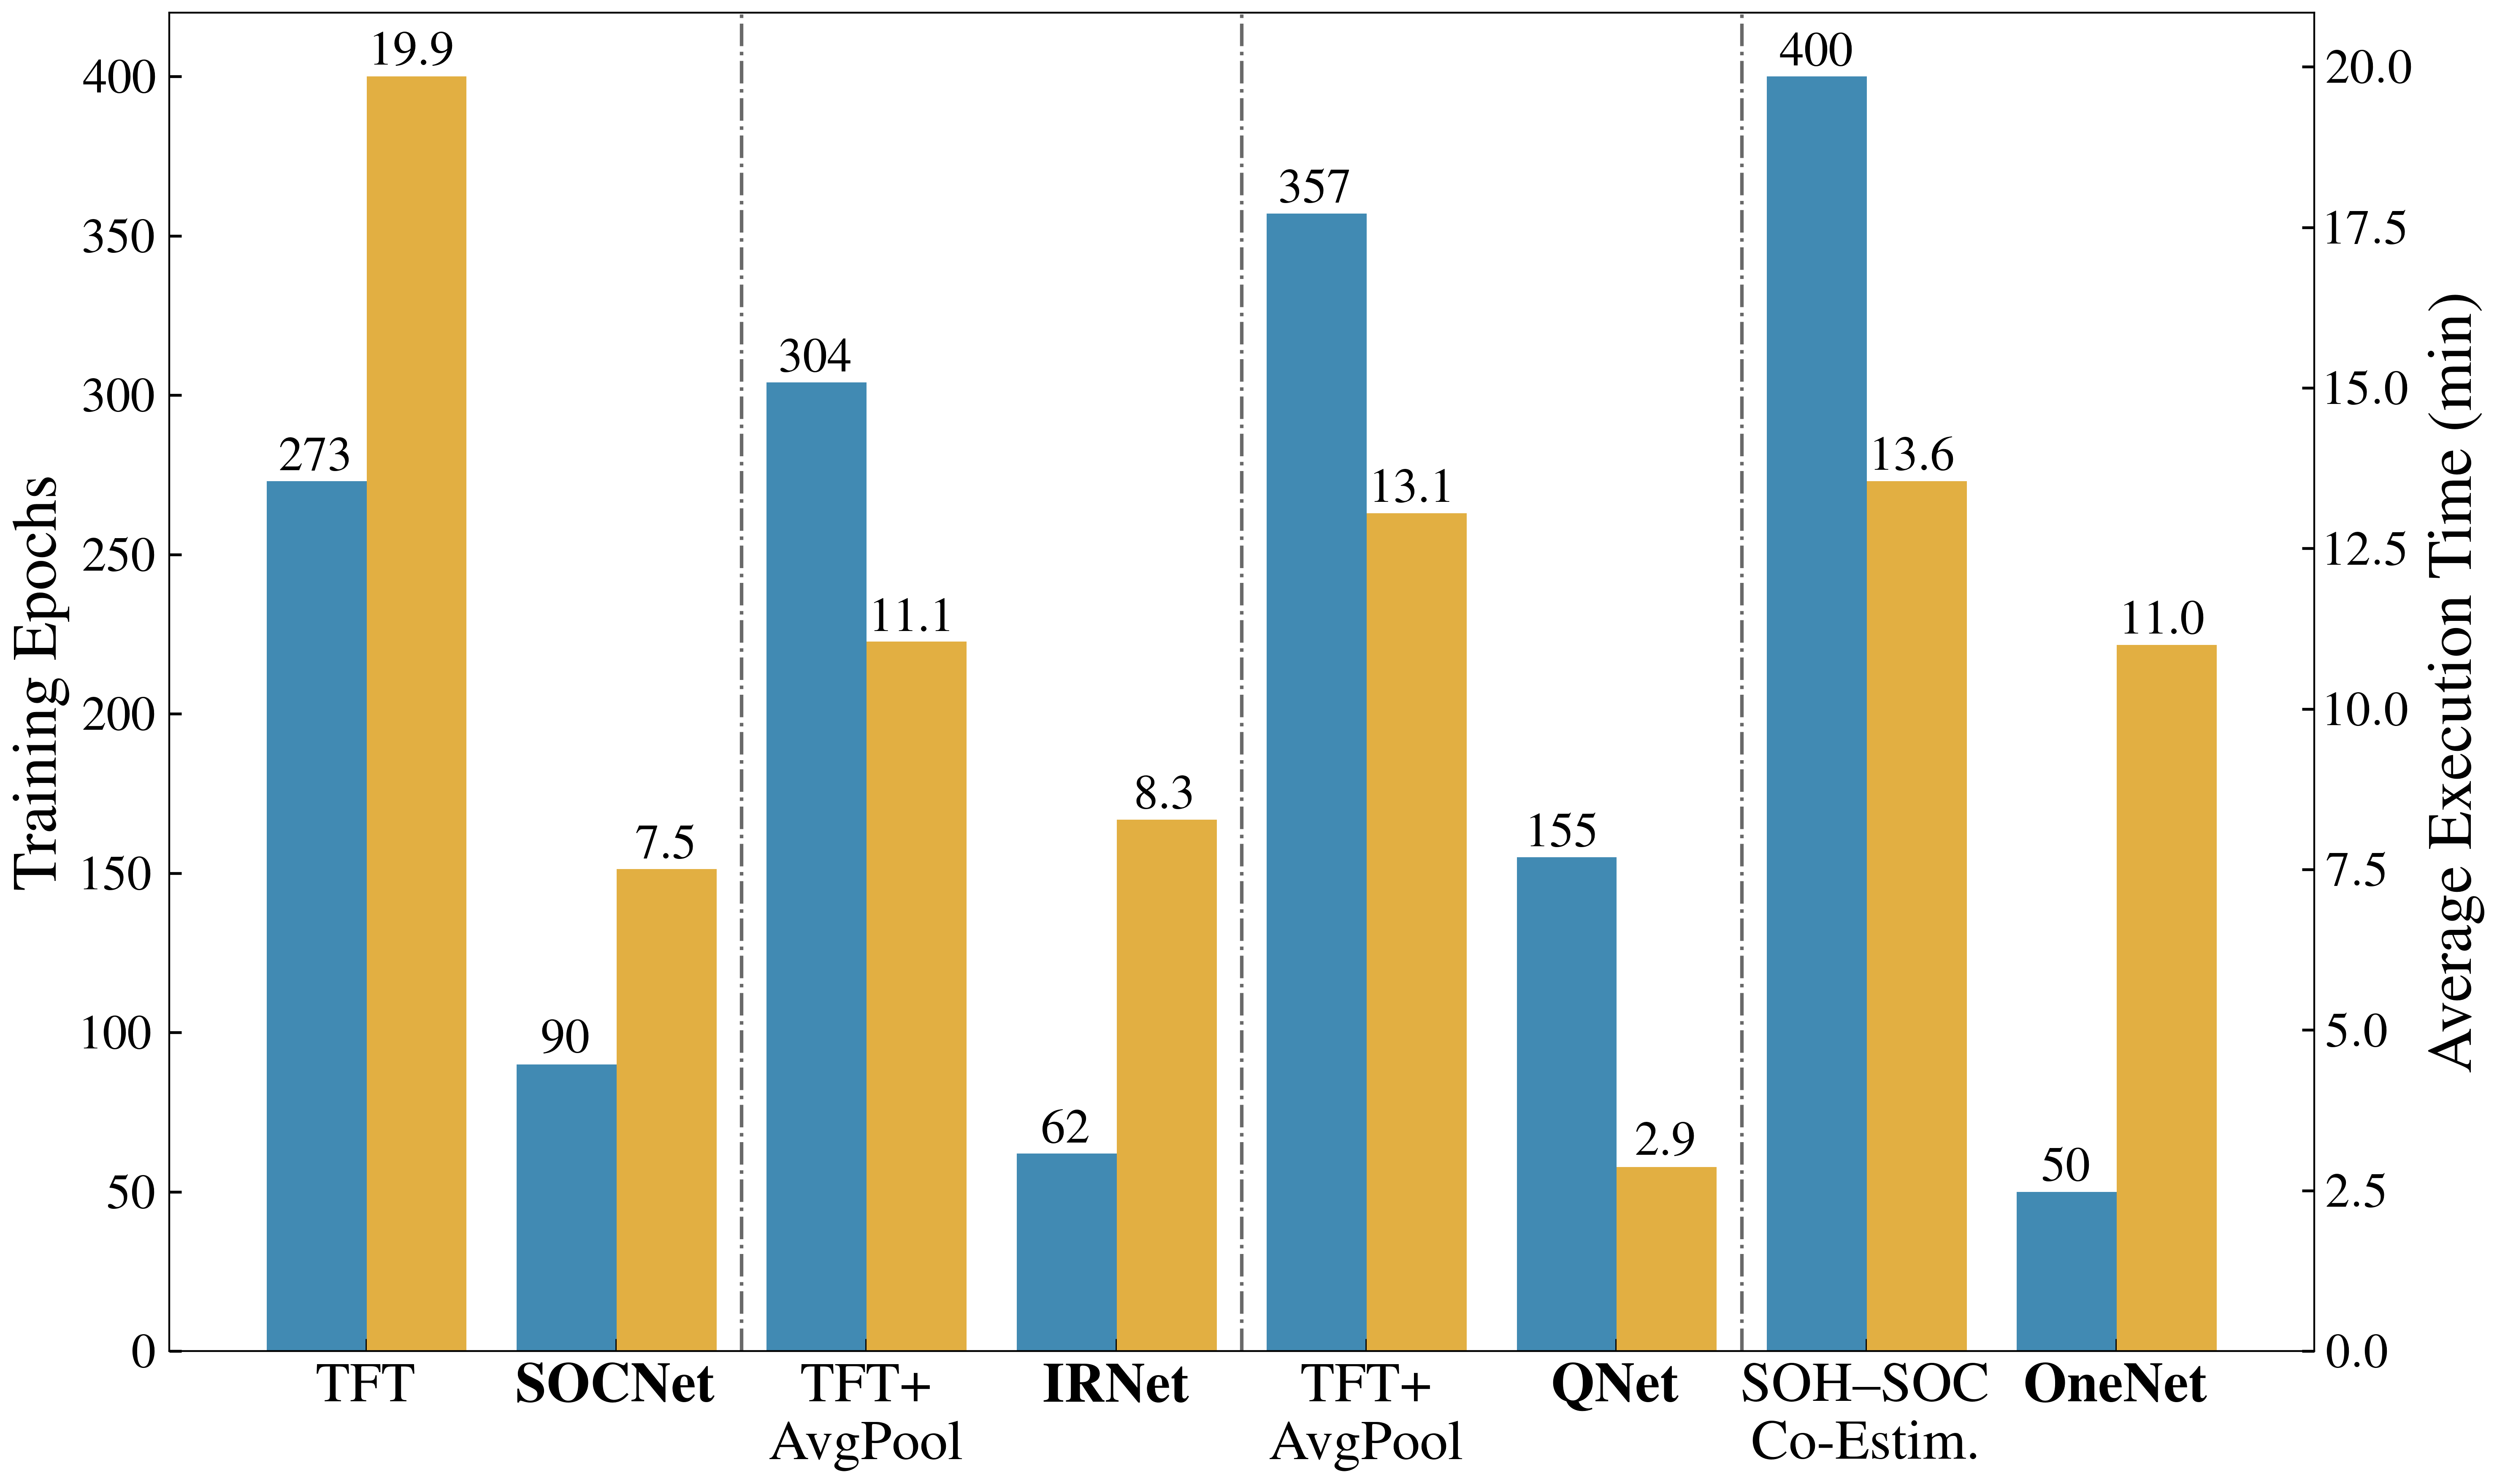

In [24]:
def plot_mich_eff(models_scales: np.ndarray, save=False):
    models_eff = pd.DataFrame(
        {
            "Name": [
                "TFT",
                r"\textbf{SOCNet}",
                "TFT+\nAvgPool",
                r"\textbf{IRNet}",
                "TFT+\nAvgPool",
                r"\textbf{QNet}",
                "SOH–SOC\nCo-Estim.",
                r"\textbf{OneNet}",
            ],
            "Params": np.concat(
                [
                    models_scales[1, [1, 3, 6, 8, 11, 13]],
                    [np.nan, np.sum(models_scales[1, [3, 8, 13]])],
                ]
            ),
            "Training Epochs": [273, 90, 304, 62, 357, 155, 400, 50],
            "Average Execution Time": [
                19.85,
                7.505,
                11.05,
                8.278,
                13.05,
                2.87,
                13.55,
                11.0,
            ],
            "Category": [
                "Attn",
                "This",
                "Attn",
                "This",
                "Attn",
                "This",
                "Other",
                "All",
            ],
        }
    )

    fig, ax = plt.subplots(figsize=(0.5 * width, 0.3 * width))
    x = np.arange(len(models_eff["Name"]))  # x轴位置
    bar_width = 0.4  # 条形宽度

    # 绘制 Training Epochs
    bar1 = ax.bar(
        x - bar_width / 2,
        models_eff["Training Epochs"],
        bar_width,
        label="Training Epochs",
        color=color_list[3],
    )
    ax.set_ylabel("Training Epochs", fontsize=fsize - 2)
    ax.bar_label(bar1, [f"{v:d}" for v in models_eff["Training Epochs"]], fontsize=fsize - 6)
    ax.tick_params(axis="y", labelsize=fsize - 6)
    ax.set_xticks(x)
    ax.set_xticklabels(models_eff["Name"], fontsize=fsize - 4)

    ax.axvline(1.5, color=color_list[-2], linestyle="dashdot")
    ax.axvline(3.5, color=color_list[-2], linestyle="dashdot")
    ax.axvline(5.5, color=color_list[-2], linestyle="dashdot")

    # 绘制 Average Execution Time
    ax2 = ax.twinx()  # 创建共享x轴的第二个y轴
    bar2 = ax2.bar(
        x + bar_width / 2,
        models_eff["Average Execution Time"],
        bar_width,
        label="Avg Exec Time",
        color=color_list[1],
    )
    ax2.set_ylabel("Average Execution Time (min)", fontsize=fsize - 2)
    ax2.bar_label(
        bar2, [f"{v:.1f}" for v in models_eff["Average Execution Time"]], fontsize=fsize - 6
    )
    ax2.tick_params(axis="y", labelsize=fsize - 6)

    # # 创建散点图
    # color_mapping = {"This": color_list[0], "Attn": color_list[1]}
    # colors = models_eff["Category"].map(color_mapping)
    # sizes = np.log10(models_eff["Params"]) * 100
    # ax.scatter(
    #     x=models_eff["Training Epochs"],
    #     y=models_eff["Average Execution Time"],
    #     s=sizes,
    #     c=colors,
    #     alpha=0.4,
    #     ec=None,
    # )
    # n = 4
    # ax.scatter(
    #     x=np.full(n, 5e2),
    #     y=[2**i * 1e-2 for i in range(n)],
    #     s=[10**i for i in range(n)],
    #     c="gray",
    #     alpha=0.4,
    #     ec=None,
    # )
    # # 添加标题和标签
    # ax.set_xlabel("Training Epochs", fontsize=fsize - 2)
    # ax.set_ylabel("Average Execution Time (min)", fontsize=fsize - 2)
    # ax.tick_params(axis="both", labelsize=fsize - 6)

    fig.tight_layout()
    if save:
        fig.savefig(
            figpath + "mich_eff.png",
            bbox_inches="tight",
            pad_inches=0.1,
            transparent=True,
        )
        resize_image(figpath + "mich_eff.png", column_width)

    return models_eff


if show_res and data_selection == "mich":
    models_eff = plot_mich_eff(models_scales, save=False)

# 其他分析

In [25]:
model_sel = input(
    "Please select deep model:\n"
    + "\n".join(
        [
            f"{k}: {v}"
            for k, v in {
                "0": "All Models",
                "1": SOCNet.__name__,
                "2": IRParamsNet.__name__,
                "3": QNet.__name__,
                "4": VoltageNet.__name__,
            }.items()
        ]
    )
)
create_load_sel = input(
    "Please select create dataset or load dataset:\n"
    + "\n".join(
        [
            f"{k}: {v}"
            for k, v in {
                "0": "Create Dataset",
                "1": "Load Dataset",
            }.items()
        ]
    )
)

# SOC 估计

## 数据预处理

In [26]:
def create_SOC_data(
    seq_len: int = 50, sample_mode="random", device=device, discharge=True
):
    with open(f"datasets/{data_selection}/cells_data.pkl", "rb") as f:
        dataset: lbw.datasets.TimeSeriesDataset = pickle.load(f)

    df_d_data_list = (
        [
            s.data.iloc[s.covariate["t_d"] : s.covariate["t_D"] + 1][
                ["t", "I", "T", "U", "SOC"]
            ]
            for s in dataset.samples
        ]
        if discharge
        else [s.data[["t", "I", "T", "U", "SOC"]] for s in dataset.samples]
    )
    sc_list = [
        [
            s.covariate["Qd"],
            s.covariate["eta_d"],
            s.covariate["IR"],
            s.data["SOC"].iat[s.covariate["t_d"]],
        ]
        for s in dataset.samples
    ]

    X = []
    SC = []
    Y = []

    with tqdm(total=len(sc_list)) as pbar:
        pbar.set_description("Complete data preparation")
        for df_d_data, sc in zip(df_d_data_list, sc_list):
            match sample_mode:
                case "rolling":
                    df_d_data = df_d_data.astype(np.float32).drop_duplicates(
                        subset="t", ignore_index=True
                    )
                    assert (df_d_data["t"].diff() != 0).all()
                    df_rolling_list = rolling_df(df_d_data, window=seq_len, stride=10)
                    X.extend(
                        [
                            df_to_tensor(df, ["t", "I", "T", "U"])
                            for df in df_rolling_list
                        ]
                    )
                    SC.extend([torch.tensor(sc)] * len(df_rolling_list))
                    Y.extend([df_to_tensor(df, ["SOC"]) for df in df_rolling_list])
                case "random":
                    df_random_list = [
                        pd.concat(
                            [
                                df_d_data.iloc[[0]],
                                (
                                    df_d_data.iloc[1:].sample(
                                        n=seq_len - 1, random_state=2023 + i
                                    )
                                    if len(df_d_data) > seq_len
                                    else resample_df(
                                        df_d_data.iloc[1:],
                                        times="t",
                                        seq_len=seq_len - 1,
                                    )
                                ),
                            ]
                        )
                        for i in range(10)
                    ]
                    X.extend(
                        [
                            df_to_tensor(df, ["t", "I", "T", "U"])
                            for df in df_random_list
                        ]
                    )
                    SC.extend([torch.tensor(sc)] * len(df_random_list))
                    Y.extend([df_to_tensor(df, ["SOC"]) for df in df_random_list])
                case _:
                    df_rsp = resample_df(df_d_data, times="t", seq_len=seq_len)
                    X.append(df_to_tensor(df_rsp, ["t", "I", "T", "U"]))
                    SC.append(torch.tensor(sc))
                    Y.append(df_to_tensor(df_rsp, ["SOC"]))
            pbar.update(1)

    X = torch.stack(X, dim=0)
    SC = torch.stack(SC, dim=0)
    Y = torch.stack(Y, dim=0)
    X = X.to(device=device, dtype=torch.float32)
    SC = SC.to(device=device, dtype=torch.float32)
    Y = Y.to(device=device, dtype=torch.float32)

    x_channels = X.shape[-1]  # 输入时间序列的特征维度
    sc_channels = SC.shape[-1]  # 静态特征的维度
    y_channels = Y.shape[-1]  # 输出时间序列的特征维度
    batch_dims = X.shape[0]

    # 检查
    assert X.shape == torch.Size([batch_dims, seq_len, x_channels])
    assert SC.shape == torch.Size([batch_dims, sc_channels])
    assert Y.shape == torch.Size([batch_dims, seq_len, y_channels])
    assert X.dtype == SC.dtype == Y.dtype
    assert X.isfinite().all() and SC.isfinite().all() and Y.isfinite().all()
    if sample_mode != "rolling" and discharge:
        assert torch.all(SC[..., 3:4] == Y[:, :1, 0])

    # 保存
    match sample_mode:
        case "resample":
            filename = f"resample_SOC_{seq_len}.pkl"
        case "random":
            filename = f"random_SOC_{seq_len}.pkl"
        case _:
            filename = f"rolling_SOC_{seq_len}.pkl"

    if not discharge:
        filename = "all_" + filename

    with open(f"datasets/{data_selection}/" + filename, "wb") as f:
        pickle.dump({"X": tensor_to_np(X, False), "SC": tensor_to_np(SC, False), "Y": tensor_to_np(Y, False)}, f)

    return X, SC, Y

## 加载模型

In [27]:
if model_sel in ["0", "1"]:
    if create_load_sel == "0":
        X, SC, Y = create_SOC_data(sample_mode="random", device=device)
    else:
        X, SC, Y = load_data(
            filename=f"datasets/{data_selection}/random_SOC_50.pkl", device=device
        )

    print(X.shape, Y.shape, SC.shape)

    model: torch.nn.Module = get_model_with_state_dict(
        f"final/{data_selection}", X, SC, SOCNet, device
    )
    # plot_tensor_data(X, Y, discharge=False)

In [28]:
def plot_tensor_data(
    X: torch.Tensor | None = None,
    Y: torch.Tensor | None = None,
    var="SOC",
    idx=0,
    discharge=True,
):
    with open(f"datasets/{data_selection}/cells_data.pkl", "rb") as f:
        dataset: lbw.datasets.TimeSeriesDataset = pickle.load(f)

    if X is None or Y is None:
        X, _, Y = load_data("datasets/a123/resample_SOC_50.pkl", SOCNet, device=device)

    idm = X.shape[0] // len(dataset)

    plt.figure(figsize=(12, 6))
    plt.xlabel("Time/s", fontsize=fsize - 2)
    plt.ylabel("Value", fontsize=fsize - 2)

    x = (
        dataset.samples[idx].data["t"][
            dataset.samples[idx]
            .covariate["t_d"] : dataset.samples[idx]
            .covariate["t_D"]
            + 1
        ]
        if discharge
        else dataset.samples[idx].data["t"]
    )
    y = (
        dataset.samples[idx].data[var][
            dataset.samples[idx]
            .covariate["t_d"] : dataset.samples[idx]
            .covariate["t_D"]
            + 1
        ]
        if discharge
        else dataset.samples[idx].data[var]
    )
    plt.plot(x, y, color="r", alpha=0.6, label="raw")

    # plt.scatter(
    #     tensor_to_np(X[0, :, 0]), tensor_to_np(Y[0, :, 0]), c="g", label=f"preprocessed"
    # )
    variable = {"t": 0, "I": 1, "T": 2, "U": 3}
    for i, idd in enumerate(range(idx * idm, (idx + 1) * idm)):
        y = (
            tensor_to_np(Y[idd, :, 0]) - i * 0.05
            if var == "SOC"
            else tensor_to_np(X[idd, :, variable[var]]) - i * 0.05
        )
        plt.scatter(tensor_to_np(X[idd, :, 0]), y)


# plot_tensor_data(var="I", idx=100)

## 单次预测

In [29]:
def predict_sample_SOC(
    model: SOCNet, X: torch.Tensor, SC: torch.Tensor, Y: torch.Tensor, index: int = 0
):
    x, sc, y = X[[index]], SC[[index]], Y[[index]]
    y_output: torch.Tensor = model(x, sc)
    y_output = tensor_to_np(y_output)
    x = tensor_to_np(x)
    y = tensor_to_np(y)
    t = x[:, 0]

    plt.plot(t, y, color="r", label="True")
    plt.plot(t, y_output, color="g", label="Estim")
    plt.legend()


# if model_sel in ["0", "1"]:
#     predict_sample_SOC(model, X, SC, Y, index=100)

## 单放电阶段预测

In [30]:
def predict_cycle_SOC(model: SOCNet, cycle=0):
    with open(f"datasets/{data_selection}/cells_data.pkl", "rb") as f:
        dataset: lbw.datasets.TimeSeriesDataset = pickle.load(f)

    data = dataset.samples[cycle].data.iloc[
        dataset.samples[cycle]
        .covariate["t_d"] : dataset.samples[cycle]
        .covariate["t_D"]
        + 1
    ]

    x = df_to_tensor(data, ["t", "I", "T", "U"], device=device).unsqueeze(0)
    y = df_to_tensor(data, ["SOC"], device=device).unsqueeze(0)
    sc = (
        torch.tensor(
            [
                dataset.samples[cycle].covariate["Qd"],
                dataset.samples[cycle].covariate["eta_d"],
                dataset.samples[cycle].covariate["IR"],
            ]
        )
        .unsqueeze(0)
        .to(device=x.device, dtype=x.dtype)
    )
    sc = torch.cat([sc, y[:, :1, 0]], dim=-1)

    y_output = model(x, sc)
    y_output = tensor_to_np(y_output)
    x = tensor_to_np(x)
    y = tensor_to_np(y)
    t = x[:, 0] - x[0, 0]
    mae = mae_function(y, y_output)
    rmse = rmse_function(y, y_output)
    mape = mape_function(y, y_output)

    plt.figure(figsize=(12, 6))
    plt.xlabel("Discharge Time [s]", fontsize=fsize - 2)
    plt.ylabel("State of Charge", fontsize=fsize - 2)
    plt.plot(
        t,
        y,
        color="r",
        alpha=0.6,
        label="True",
    )
    plt.scatter(t, y_output, c="g", label="Estim")
    plt.legend(fontsize=fsize - 4)

    plt.text(
        0.5,
        0.25,
        f"Criteria: \nMAE={mae:.5f}\nMAPE={mape * 100:.4}%%\nRMSE={rmse:.5f}",
        fontdict=dict(fontsize=18),
    )

    return mae, mape, rmse


# if model_sel in ["0", "1"]:
#     predict_cycle_SOC(model, 200)

# 参数辨识与内阻估计

In [31]:
params_list = [
    "t",
    "I",
    "T",
    "U",
    "SOC",  # x
    "R_1",
    "1/R_1C_1",
    "OCV - U",
    "-M_H",
    "K_H",  # theta
    "U_H",
    "U_1",  # voltages
]

## 数据预处理

In [32]:
def create_IR_data(seq_len: int = 50, sample_mode="rolling", device=device):
    with open(f"datasets/{data_selection}/cells_data.pkl", "rb") as f:
        dataset: lbw.datasets.TimeSeriesDataset = pickle.load(f)

    df_d_data_list = [
        s.data.iloc[s.covariate["t_d"] : s.covariate["t_D"] + 1][
            ["t", "I", "T", "U", "SOC"]
        ]
        for s in dataset.samples
    ]
    sc_list = [
        [s.covariate["Qd"], s.covariate["eta_d"], s.covariate["IR"]]
        for s in dataset.samples
    ]
    y_list = [[s.covariate["IR"]] for s in dataset.samples]

    X = []
    SC = []
    Y = []

    with tqdm(total=len(sc_list)) as pbar:
        pbar.set_description("Complete data preparation")
        for df_d_data, sc, y in zip(df_d_data_list, sc_list, y_list):
            match sample_mode:
                case "resample":
                    df_rsp = resample_df(df_d_data, times="t", seq_len=seq_len)
                    X.append(df_to_tensor(df_rsp, ["t", "I", "T", "U", "SOC"]))
                    SC.append(torch.tensor(sc))
                    Y.append(torch.tensor(y))
                case "random":
                    df_random_list = [
                        (
                            df_d_data.sample(n=seq_len, random_state=2023 + i)
                            if len(df_d_data) > seq_len
                            else resample_df(
                                df_d_data,
                                times="t",
                                seq_len=seq_len,
                            )
                        )
                        for i in range(10)
                    ]
                    X.extend(
                        [
                            df_to_tensor(df, ["t", "I", "T", "U", "SOC"])
                            for df in df_random_list
                        ]
                    )
                    SC.extend([torch.tensor(sc)] * len(df_random_list))
                    Y.extend([torch.tensor(y)] * len(df_random_list))
                case _:
                    df_d_data = df_d_data.astype(np.float32).drop_duplicates(
                        subset="t", ignore_index=True
                    )
                    assert (df_d_data["t"].diff() != 0).all()
                    df_rolling_list = rolling_df(df_d_data, window=seq_len, stride=10)
                    X.extend(
                        [
                            df_to_tensor(df, ["t", "I", "T", "U", "SOC"])
                            for df in df_rolling_list
                        ]
                    )
                    SC.extend([torch.tensor(sc)] * len(df_rolling_list))
                    Y.extend([torch.tensor(y)] * len(df_rolling_list))
            pbar.update(1)

    X = torch.stack(X, dim=0)
    SC = torch.stack(SC, dim=0)
    Y = torch.stack(Y, dim=0)
    X = X.to(device=device, dtype=torch.float32)
    SC = SC.to(device=device, dtype=torch.float32)
    Y = Y.to(device=device, dtype=torch.float32)

    x_channels = X.shape[-1]  # 输入时间序列的特征维度
    sc_channels = SC.shape[-1]  # 静态特征的维度
    y_channels = Y.shape[-1]  # 输出特征的维度
    batch_dims = X.shape[0]

    # 检查
    assert X.shape == torch.Size([batch_dims, seq_len, x_channels])
    assert SC.shape == torch.Size([batch_dims, sc_channels])
    assert Y.shape == torch.Size([batch_dims, y_channels])
    assert X.dtype == Y.dtype == SC.dtype
    assert X.isfinite().all() and SC.isfinite().all() and Y.isfinite().all()

    # 保存
    match sample_mode:
        case "resample":
            filename = f"resample_IR_{seq_len}.pkl"
        case "random":
            filename = f"random_IR_{seq_len}.pkl"
        case _:
            filename = f"rolling_IR_{seq_len}.pkl"

    with open(f"datasets/{data_selection}/" + filename, "wb") as f:
        pickle.dump({"X": tensor_to_np(X, False), "SC": tensor_to_np(SC, False), "Y": tensor_to_np(Y, False)}, f)

    return X, SC, Y

## 加载模型

In [33]:
if model_sel in ["0", "2"]:
    if create_load_sel == "0":
        X, SC, Y = create_IR_data(sample_mode="random", device=device)
    else:
        X, SC, Y = load_data(
            filename=f"datasets/{data_selection}/random_IR_50.pkl", device=device
        )
    print(X.shape, Y.shape, SC.shape)
    model: torch.nn.Module = get_model_with_state_dict(
        f"final/{data_selection}", X, SC, IRParamsNet, device, dataset=data_selection
    )
    # plt.plot(tensor_to_np(X[0, :, 0]))

## 参数估计

### 估计并保存

In [34]:
def estimate_params(model: IRParamsNet):
    assert isinstance(model, IRParamsNet)
    with open(f"datasets/{data_selection}/cells_data.pkl", "rb") as f:
        dataset: lbw.datasets.TimeSeriesDataset = pickle.load(f)

    params_dataset = lbw.datasets.TimeSeriesDataset()

    with tqdm(total=9) as pbar:
        pbar.set_description("Complete params estimation")

        pbar.set_postfix_str("Compute df_xs")
        df_xs: list[pd.DataFrame] = [
            s.data.iloc[s.covariate["t_d"] : s.covariate["t_D"] + 1]
            for s in dataset.samples
        ]
        pbar.update(1)

        pbar.set_postfix_str("Compute xs")
        xs = [df_to_tensor(df_x, ["t", "I", "T", "U", "SOC"]) for df_x in df_xs]
        xs = pad_sequence(xs, batch_first=True, padding_value=torch.nan)
        pbar.update(1)

        pbar.set_postfix_str("Compute scs")
        scs = [
            torch.tensor(
                [s.covariate["Qd"], s.covariate["eta_d"], s.covariate["IR"]],
                dtype=xs.dtype,
                device=xs.device,
            )
            for s in dataset.samples
        ]
        scs = torch.stack(scs, dim=0)
        pbar.update(1)

        pbar.set_postfix_str("Compute outputs")
        _, thetas, voltages = model.forward(xs, scs, return_params=True)
        thetas: torch.Tensor
        voltages: torch.Tensor
        pbar.update(1)

        pbar.set_postfix_str("Compute df_xs")
        df_xs = [
            tensor_to_df(x, ["t", "I", "T", "U", "SOC"]).dropna(
                axis=0, how="any", ignore_index=True
            )
            for x in xs
        ]
        pbar.update(1)

        pbar.set_postfix_str("Compute df_thetas")
        df_thetas: list[pd.DataFrame] = [
            tensor_to_df(theta, ["R_1", "1/R_1C_1", "OCV - U", "-M_H", "K_H"]).dropna(
                axis=0, how="any", ignore_index=True
            )
            for theta in thetas
        ]
        pbar.update(1)

        pbar.set_postfix_str("Compute df_voltages")
        df_voltages: list[pd.DataFrame] = [
            tensor_to_df(voltage, ["U_H", "U_1"]).dropna(
                axis=0, how="any", ignore_index=True
            )
            for voltage in voltages
        ]
        pbar.update(1)

        pbar.set_postfix_str("Compute df_datas")
        df_datas: list[pd.DataFrame] = [
            pd.concat([x, theta, voltage], axis=1)
            for x, theta, voltage in zip(df_xs, df_thetas, df_voltages)
        ]
        pbar.update(1)

        pbar.set_postfix_str("Compute scs")
        scs: list[dict] = [
            {
                "Qd": s.covariate["Qd"],
                "eta_d": s.covariate["eta_d"],
                "IR": s.covariate["IR"],
                "RUL": s.covariate["RUL"],
                "barcode": s.covariate["barcode"],
            }
            for s in dataset.samples
        ]
        pbar.update(1)

    samples = [lbw.samples.TimeSeries(data, sc) for data, sc in zip(df_datas, scs)]
    params_dataset.extend(samples)
    with open(f"datasets/{data_selection}/cells_data_with_params.pkl", "wb") as f:
        pickle.dump(params_dataset, f)

    return params_dataset


if train_done and model_sel in ["0", "2"]:
    if input("Estimate params and prepare cells data with params [y/n]") == "y":
        params_dataset = estimate_params(model)

### 估计图

In [35]:
def plot_estimate_vars(
    barcode: str,
    cycle_max=None,
    cycle_step=None,
    x_label="time",
    save=False,
):
    with open("datasets/a123/cells_data_with_params.pkl", "rb") as f:
        dataset: lbw.datasets.TimeSeriesDataset = pickle.load(f)
    samples = dataset.select("barcode", barcode)
    cycle_max = len(samples) if cycle_max is None else cycle_max
    cycle_step = cycle_max // 15 if cycle_step is None else cycle_step

    variables = [
        # "T",
        "OCV",
        "R_1",
        # "C_1",
        "K_H",
        # "t",
        # "U_1",
        # "SOC",
        # "-M_H",
    ]
    vars_label = [
        # "Temperature (℃)",
        r"\(OCV\) (V)",
        r"\(R_1\) (\(10^{-3} \Omega\))",
        # r"\(C_1\) (F)",
        r"\(K_H\) (\(10^{-6} \text{A}^{-1}\text{s}^{-1}\))",
        # "Time (min)",
        # r"\(U_1\) (V)",
        # r"\(SOC\) (\%)",
        # r"\(M_H\) (V)",
    ]

    # 创建图形对象
    fig, axes = plt.subplots(
        nrows=len(variables),
        ncols=1,
        figsize=(0.4 * width, 0.35 * width),
        sharex=True,
    )
    axes: list[Axes] = axes.flatten()

    for i, ax in enumerate(axes):
        for cycle in range(0, cycle_max, cycle_step):
            x = (
                samples[cycle].data["t"]
                if x_label == "time"
                else samples[cycle].data[x_label]
            )
            match variables[i]:
                case "OCV":
                    y = samples[cycle].data["OCV - U"] + samples[cycle].data["U"]
                case "C_1":
                    y = 1 / (
                        samples[cycle].data["1/R_1C_1"] * samples[cycle].data["R_1"]
                    )
                case _:
                    y = samples[cycle].data[variables[i]]
            ax.plot(
                x,
                y,
                color=color_list[i],
                alpha=1 - cycle / cycle_max,
                ls="-" if cycle == 0 else "-.",
                lw=2 if cycle == 0 else 1,
            )

        if i >= len(axes) - 1:
            if x_label == "time":
                ax.set_xlabel("Discharge Time (min)", fontsize=fsize - 2)
            else:
                ax.set_xlabel(r"\(SOC\) (\%)", fontsize=fsize - 2)
        if x_label == "SOC":
            ax.xaxis.set_major_formatter(
                ticker.FuncFormatter(lambda x, pos: f"{int(x * 100):2d}")
            )
        if max(y) - min(y) > 10:
            ax.yaxis.set_major_formatter(ticker.FormatStrFormatter("%d"))
        elif 1e-4 < max(y) - min(y) < 1e-3:
            ax.yaxis.set_major_formatter(
                ticker.FuncFormatter(lambda x, pos: f"{int(x * 1e3):.2f}")
            )
            # ax.text(0.01, 0.95, r"\(\times 10^{-3}\)", fontsize=fsize - 4, ha="left", va="top", transform=ax.transAxes)
        elif max(y) - min(y) < 1e-4:
            ax.yaxis.set_major_formatter(
                ticker.FuncFormatter(lambda x, pos: f"{int(x * 1e6):d}")
            )
            # ax.text(0.01, 0.95, r"\(\times 10^{-6}\)", fontsize=fsize - 4, ha="left", va="top", transform=ax.transAxes)
        else:
            ax.yaxis.set_major_formatter(ticker.FormatStrFormatter("%.3f"))
        ax.set_ylabel(vars_label[i], fontsize=fsize - 2)
        ax.yaxis.set_label_coords(-0.1, 0.5)
        ax.tick_params("both", labelsize=fsize - 4)

    fig.tight_layout()
    if save:
        fig.savefig(
            figpath + "variable.png",
            bbox_inches="tight",
            pad_inches=0.1,
            transparent=True,
        )
        resize_image(figpath + "variable.png", column_width)


if model_sel in ["0", "2"] and show_res and data_selection == "a123":
    plot_estimate_vars(cells_barcode[2], x_label="SOC", save=False)

## 内阻估计

In [36]:
def estim_resistance(model: IRParamsNet, barcode: str, fast=False):
    with open(f"datasets/{data_selection}/cells_data.pkl", "rb") as f:
        dataset: lbw.datasets.TimeSeriesDataset = pickle.load(f)

    with tqdm(total=5, disable=True) as pbar:
        pbar.set_description("Complete estimation")

        pbar.set_postfix_str("Select samples")
        samples: list[lbw.samples.TimeSeries] = dataset.select("barcode", barcode)
        pbar.update(1)

        pbar.set_postfix_str("Prepare X")
        if fast:
            X = pad_sequence(
                [
                    df_to_tensor(
                        s.data.iloc[s.covariate["t_d"] : s.covariate["t_D"] + 1][
                            ["t", "I", "T", "U", "SOC"]
                        ],
                        ["t", "I", "T", "U", "SOC"],
                        device=device,
                        dtype=torch.float32,
                    )
                    for s in samples
                ],
                batch_first=True,
                padding_value=torch.nan,
            )
        else:
            X = torch.stack(
                [
                    df_to_tensor(
                        resample_df(
                            s.data.iloc[s.covariate["t_d"] : s.covariate["t_D"] + 1][
                                ["t", "I", "T", "U", "SOC"]
                            ],
                            times="t",
                            seq_len=50,
                        ),
                        ["t", "I", "T", "U", "SOC"],
                        device=device,
                        dtype=torch.float32,
                    )
                    for s in samples
                ],
                dim=0,
            )
        pbar.update(1)

        pbar.set_postfix_str("Prepare SC")
        SC = torch.stack(
            [
                torch.tensor(
                    [s.covariate["Qd"], s.covariate["eta_d"], s.covariate["IR"]],
                    device=device,
                    dtype=torch.float32,
                )
                for s in samples
            ],
            dim=0,
        )
        pbar.update(1)

        pbar.set_postfix_str("Estimate")
        IR_estim = model.forward(X, SC)
        pbar.update(1)

        pbar.set_postfix_str("Prepare data")
        cycles = [c + 1 for c in range(len(samples))]
        IR_true = [s.covariate["IR"] for s in samples]
        IR_estim = tensor_to_np(IR_estim)
        pbar.update(1)

    plt.figure()
    plt.xlabel("Cycle", fontsize=fsize - 2)
    plt.ylabel("Value", fontsize=fsize - 2)
    plt.plot(
        cycles,
        IR_true,
        color="r",
        alpha=0.6,
        label="raw",
    )
    plt.scatter(cycles, IR_estim, c="g", label="Estim")
    plt.legend(fontsize=fsize - 4)

    return X, SC, IR_true, IR_estim


if train_done and show_res and model_sel in ["0", "2"]:
    for bc in cells_barcode:
        X, SC, IR_true, IR_estim = estim_resistance(model, bc)

# 剩余容量估计

## 数据预处理

In [37]:
def create_Q_data(sample_mode: str = "random", seq_len: int = 50, device=device):
    with open(f"datasets/{data_selection}/cells_data_with_params.pkl", "rb") as f:
        dataset: lbw.datasets.TimeSeriesDataset = pickle.load(f)

    x_list = [s.data[params_list] for s in dataset.samples]

    sc_list = [
        [
            s.covariate["IR"],
            s.covariate["eta_d"],
            s.covariate["Qd"] + 2e-3 * np.random.randn() + 1e-5,
        ]
        for s in dataset.samples
    ]

    y_list = [[s.covariate["Qd"]] for s in dataset.samples]

    X = []
    SC = []
    Y = []

    with tqdm(total=len(sc_list)) as pbar:
        pbar.set_description("Complete data preparation")
        for df_x, sc, y in zip(x_list, sc_list, y_list):
            if sample_mode == "random":
                weights = (
                    np.cos(
                        np.pi
                        * seq_len
                        * (df_x["t"] - df_x["t"].iat[0])
                        / (df_x["t"].iat[-1] - df_x["t"].iat[0])
                    )
                    ** 2
                )
                df_random_list = [
                    (
                        df_x.sample(
                            n=seq_len, weights=weights, random_state=2023 + i
                        ).sort_index()
                        if len(df_x) > seq_len
                        else resample_df(df_x, times="t", seq_len=seq_len)
                    )
                    for i in range(10)
                ]

                X.extend([df_to_tensor(df, params_list) for df in df_random_list])
                SC.extend([torch.tensor(sc)] * len(df_random_list))
                Y.extend([torch.tensor(y)] * len(df_random_list))
            else:
                df_x_rsp = resample_df(df_x, times="t", seq_len=seq_len)
                X.append(df_to_tensor(df_x_rsp, params_list))
                SC.append(torch.tensor(sc))
                Y.append(torch.tensor(y))
            pbar.update(1)

    X = torch.stack(X, dim=0)

    X[:, :, 0] = X[:, :, 0] - X[:, :1, 0]  # 减去首个时间
    SC = torch.stack(SC, dim=0)
    Y = torch.stack(Y, dim=0)
    X = X.to(device=device, dtype=torch.float32)
    SC = SC.to(device=device, dtype=torch.float32)
    Y = Y.to(device=device, dtype=torch.float32)

    x_channels = X.shape[-1]  # 输入时间序列的特征维度
    sc_channels = SC.shape[-1]  # 静态特征的维度
    y_channels = Y.shape[-1]  # 输出特征的维度
    batch_dims = X.shape[0]

    # 检查
    assert X.shape == torch.Size([batch_dims, seq_len, x_channels])
    assert SC.shape == torch.Size([batch_dims, sc_channels])
    assert Y.shape == torch.Size([batch_dims, y_channels])
    assert X.dtype == SC.dtype == Y.dtype
    assert X.isfinite().all() and SC.isfinite().all() and Y.isfinite().all()

    # 保存
    if sample_mode == "random":
        filename = f"random_Q_{seq_len}.pkl"
    else:
        filename = f"resample_Q_{seq_len}.pkl"
    with open(f"datasets/{data_selection}/" + filename, "wb") as f:
        pickle.dump({"X": tensor_to_np(X, False), "SC": tensor_to_np(SC, False), "Y": tensor_to_np(Y, False)}, f)

    return X, SC, Y

## 加载模型

In [38]:
if model_sel in ["0", "3"]:
    if create_load_sel == "0":
        X, SC, Y = create_Q_data(device=device)
    else:
        X, SC, Y = load_data(filename=f"datasets/{data_selection}/random_Q_50.pkl", device=device)
    print(X.shape, Y.shape, SC.shape)
    model: torch.nn.Module = get_model_with_state_dict(
        f"final/{data_selection}", X, SC, QNet, device
    )
    # plt.plot(tensor_to_np(X[0, :, 0]))

## 容量估计

In [39]:
def estim_capacity(model: QNet, barcode: str):
    with open(f"datasets/{data_selection}/cells_data_with_params.pkl", "rb") as f:
        dataset: lbw.datasets.TimeSeriesDataset = pickle.load(f)

    samples: list[lbw.samples.TimeSeries] = dataset.select("barcode", barcode)
    X = torch.stack(
        [
            df_to_tensor(
                resample_df(s.data[params_list], times="t", seq_len=50),
                params_list,
                device=device,
                dtype=torch.float32,
            )
            for s in samples
        ],
        dim=0,
    )
    X[:, :, 0] = X[:, :, 0] - X[:, :1, 0]  # 减去首个时间
    SC = torch.stack(
        [
            torch.tensor(
                [
                    s.covariate["IR"],
                    s.covariate["eta_d"],
                    s.covariate["Qd"] + 2e-3 * np.random.randn() + 1e-5,
                ],
                device=device,
                dtype=torch.float32,
            )
            for s in samples
        ],
        dim=0,
    )
    Q_estim = model.forward(X, SC)
    cycles = [c + 1 for c in range(len(samples))]
    Q_true = [s.covariate["Qd"] for s in samples]
    Q_estim = tensor_to_np(Q_estim)

    plt.figure()
    plt.xlabel("Cycle", fontsize=fsize - 2)
    plt.ylabel("Value", fontsize=fsize - 2)
    plt.plot(
        cycles,
        Q_true,
        color="r",
        alpha=0.6,
        label="raw",
    )
    plt.scatter(cycles, Q_estim, c="g", label="Estim")
    plt.legend(fontsize=fsize - 4)

    return X, SC, Q_true, Q_estim


if train_done and show_res and model_sel in ["0", "3"]:
    for bc in cells_barcode:
        X, SC, Q_true, Q_estim = estim_capacity(model, bc)

## 模型解释

In [40]:
def plot_attn(model: QNet, X: torch.Tensor, SC: torch.Tensor, save=False):
    _, channel_attn, _ = model.forward(X, SC, return_attn=True)
    channel_attn = tensor_to_np(channel_attn)  # [batch_dims, x_channels]
    ylabels = [
        r"\(t\)",
        r"\(I\)",
        r"\(T\)",
        r"\(U\)",
        r"\(SOC\)",
        r"\(R_1\)",
        r"\(1/R_1C_1\)",
        r"\(OCV - U\)",
        r"\(-M_H\)",
        r"\(K_H\)",
        r"\(U_H\)",
        r"\(U_1\)",
    ]

    df_corr_xs = pd.DataFrame(
        data=np.stack(
            [
                np.mean(channel_attn, axis=0),
                np.median(channel_attn, axis=0),
                np.max(channel_attn, axis=0),
                np.min(channel_attn, axis=0),
                np.std(channel_attn, axis=0),
            ],
            axis=-1,
        ),
        columns=["Mean", "Median", "Max", "Min", "Std"],
    )

    # 创建图形
    fig, ax = plt.subplots(figsize=(0.5 * width, 0.3 * width))
    ax = sns.heatmap(
        df_corr_xs,
        center=0.5,
        vmin=0.0,
        vmax=1.0,
        annot=True,
        fmt=".4f",
        annot_kws={"fontsize": fsize - 6},
        cmap="YlOrRd",
        ax=ax,
    )

    from matplotlib.patches import Rectangle

    for row in range(len(ylabels)):
        ax.add_patch(Rectangle((4, row), 1, 1, fill=True, color="w", edgecolor=None))

    # ax.set_xlabel("Channel Attention Statistical Value", fontsize=fsize - 3)
    # ax.set_ylabel("Feature", fontsize=fsize - 3)
    ax.tick_params(axis="both", labelsize=fsize - 6, labelrotation=0)
    ax.set_yticks(
        ticks=[x + 0.5 for x in range(len(ylabels))],
        labels=ylabels,
    )
    ax.axhline(y=4, color=color_list[-2], linestyle="dashdot")
    ax.axhline(y=5, color=color_list[-2], linestyle="dashdot")
    ax.spines[:].set_visible(True)
    ax.collections[0].colorbar.ax.tick_params(labelsize=fsize - 6)

    # fig = plt.figure(figsize=(0.5 * width, 0.3 * width))
    # ax = fig.add_subplot()
    # bplot = ax.boxplot(
    #     channel_attn,
    #     notch=True,
    #     sym="o",
    #     vert=True,
    #     whis=(0, 100),
    #     autorange=True,
    #     patch_artist=True,
    #     tick_labels=params_list,
    #     medianprops={"color": "w"},
    # )

    # from matplotlib.patches import PathPatch

    # for patch, color in zip(bplot["boxes"], color_list):
    #     patch: PathPatch
    #     patch.set_facecolor(color)
    # ax.axvline(x=4.5, color="grey", linestyle="--")

    fig.tight_layout()
    if save:
        fig.savefig(
            figpath + "attn.png",
            bbox_inches="tight",
            pad_inches=0.1,
            transparent=True,
        )
        resize_image(figpath + "attn.png", column_width)


# if model_sel in ["0", "3"] and show_res and data_selection == "a123":
#     plot_attn(model, X, SC, save=False)

In [41]:
def plot_corr(X: torch.Tensor, save=False):
    coef = torch.corrcoef(X.view(X.shape[0] * X.shape[-2], X.shape[-1]).T)
    coef = tensor_to_np(coef)

    ylabels = [
        r"\(t\)",
        r"\(I\)",
        r"\(T\)",
        r"\(U\)",
        r"\(SOC\)",
        r"\(R_1\)",
        r"\(1/R_1C_1\)",
        r"\(OCV - U\)",
        r"\(-M_H\)",
        r"\(K_H\)",
        r"\(U_H\)",
        r"\(U_1\)",
    ]

    fig, ax = plt.subplots(figsize=(0.55 * width, 0.5 * width))
    ax = sns.heatmap(
        coef,
        annot=True,
        cmap="coolwarm",
        fmt=".3f",
        annot_kws={"fontsize": fsize - 6},
        cbar=False,
        ax=ax,
    )

    ax.tick_params(axis="both", labelsize=fsize - 6, labelrotation=0)
    ax.set_xticks(
        ticks=[x + 0.5 for x in range(len(ylabels))],
        labels=ylabels,
    )
    ax.set_yticks(
        ticks=[x + 0.5 for x in range(len(ylabels))],
        labels=ylabels,
    )

    ax.set_aspect("equal")
    fig.tight_layout()
    if save:
        fig.savefig(
            figpath + "corr.png",
            bbox_inches="tight",
            pad_inches=0.1,
            transparent=True,
        )


# if model_sel in ["0", "3"] and show_res and data_selection == "a123":
#     plot_corr(X, save=False)

# 电压预测

## 数据预处理

In [42]:
def create_Voltage_data(seq_len: int = 50, sample_mode="rolling", device=device):
    with open(f"datasets/{data_selection}/cells_data.pkl", "rb") as f:
        dataset: lbw.datasets.TimeSeriesDataset = pickle.load(f)

    df_d_data_list = [
        s.data.iloc[s.covariate["t_d"] : s.covariate["t_D"] + 1][
            ["t", "I", "T", "U"]
        ]
        for s in dataset.samples
    ]
    sc_list = [
        [s.covariate["Qd"], s.covariate["IR"]]
        for s in dataset.samples
    ]

    X = []
    SC = []
    Y = []

    with tqdm(total=len(sc_list)) as pbar:
        pbar.set_description("Complete data preparation")
        for df_d_data, sc in zip(df_d_data_list, sc_list):
            if sample_mode == "resample":
                df_rsp = resample_df(df_d_data, times="t", seq_len=seq_len)
                X.append(df_to_tensor(df_rsp, ["t", "I", "T"]))
                SC.append(torch.tensor(sc))
                Y.append(df_to_tensor(df_rsp, ["U"]))
            elif sample_mode == "random":
                df_random_list = [
                    pd.concat(
                            [
                                df_d_data.iloc[[0]],
                                (
                                    df_d_data.iloc[1:].sample(
                                        n=seq_len - 1, random_state=2023 + i
                                    ).sort_index()
                                    if len(df_d_data) > seq_len
                                    else resample_df(
                                        df_d_data.iloc[1:],
                                        times="t",
                                        seq_len=seq_len - 1,
                                    )
                                ),
                            ]
                        )
                    for i in range(10)
                ]
                X.extend(
                    [
                        df_to_tensor(df, ["t", "I", "T"])
                        for df in df_random_list
                    ]
                )
                SC.extend([torch.tensor(sc)] * len(df_random_list))
                Y.extend([df_to_tensor(df, ["U"]) for df in df_random_list])
            else:
                df_rolling_list = rolling_df(df_d_data, window=seq_len, stride=10)
                X.extend(
                    [
                        df_to_tensor(df, ["t", "I", "T"])
                        for df in df_rolling_list
                    ]
                )
                SC.extend([torch.tensor(sc)] * len(df_rolling_list))
                Y.extend([df_to_tensor(df, ["U"]) for df in df_rolling_list])

            pbar.update(1)

    X = torch.stack(X, dim=0)
    SC = torch.stack(SC, dim=0)
    Y = torch.stack(Y, dim=0)
    X = X.to(device=device, dtype=torch.float32)
    SC = SC.to(device=device, dtype=torch.float32)
    Y = Y.to(device=device, dtype=torch.float32)

    x_channels = X.shape[-1]  # 输入时间序列的特征维度
    sc_channels = SC.shape[-1]  # 静态特征的维度
    y_channels = Y.shape[-1]  # 输出特征的维度
    batch_dims = X.shape[0]

    # 检查
    assert X.shape == torch.Size([batch_dims, seq_len, x_channels])
    assert SC.shape == torch.Size([batch_dims, sc_channels])
    assert Y.shape == torch.Size([batch_dims, seq_len, y_channels])
    assert X.dtype == Y.dtype == SC.dtype
    assert X.isfinite().all() and SC.isfinite().all() and Y.isfinite().all()

    # 保存
    if sample_mode == "resample":
        filename = f"datasets/{data_selection}/resample_Voltage_{seq_len}.pkl"
    elif sample_mode == "random":
        filename = f"datasets/{data_selection}/random_Voltage_{seq_len}.pkl"
    else:
        filename = f"datasets/{data_selection}/rolling_Voltage_{seq_len}.pkl"

    with open(filename, "wb") as f:
        pickle.dump({"X": tensor_to_np(X, False), "SC": tensor_to_np(SC, False), "Y": tensor_to_np(Y, False)}, f)

    return X, SC, Y

In [43]:
if model_sel in ["0", "4"] and data_selection == "mich":
    if create_load_sel == "0":
        X, SC, Y = create_Voltage_data(sample_mode="random", device=device)
    else:
        X, SC, Y = load_data(
            filename=f"datasets/{data_selection}/random_Voltage_50.pkl", device=device
        )
    print(X.shape, Y.shape, SC.shape)
    model: torch.nn.Module = get_model_with_state_dict(
        f"final/{data_selection}", X, SC, VoltageNet, device, dataset=data_selection
    )
    # print("\n".join([f"{p[0]}:\n{p[1].data.tolist()}" for p in model.named_parameters()]))

torch.Size([65160, 50, 3]) torch.Size([65160, 50, 1]) torch.Size([65160, 2])


MAE: 0.0615, RMSE: 0.0775, MAPE: 1.71%


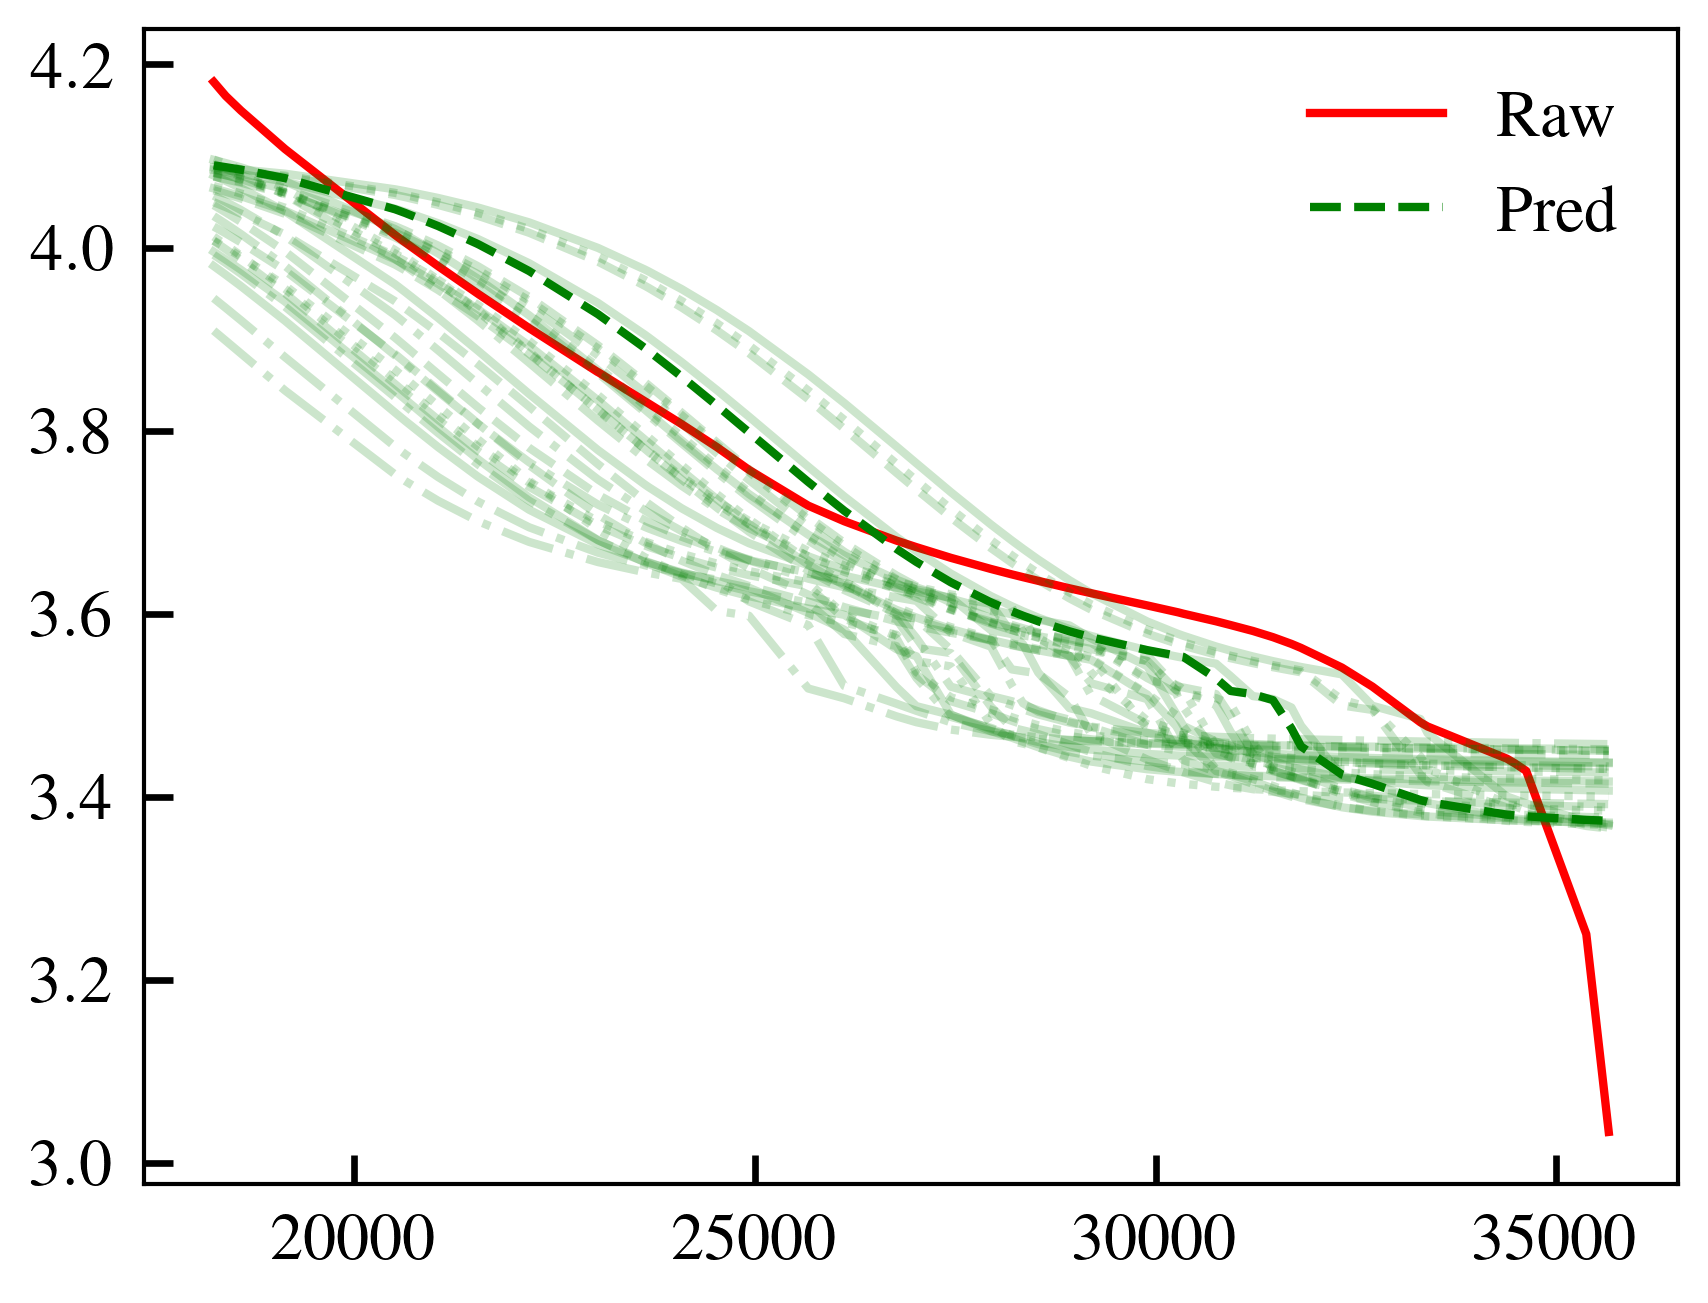

In [50]:
def predict_voltage(
    model: VoltageNet, X: torch.Tensor, SC: torch.Tensor, Y: torch.Tensor, idx: int = 0, n_samples: int = 30
):
    assert isinstance(model, VoltageNet)
    x, sc, y = X[[idx]], SC[[idx]], Y[[idx]]
    a, _ = SC.min(dim=0, keepdim=True)
    b, _ = SC.max(dim=0, keepdim=True)
    sc_rs = a + (b - a) * torch.rand(n_samples, SC.shape[-1], dtype=SC.dtype, device=SC.device)
    # print(sc_rs)
    y_output = tensor_to_np(model(x, sc))
    y_rs = [tensor_to_np(model(x, sc_rs[[i]])) for i in range(n_samples)]
    x = tensor_to_np(x)
    y = tensor_to_np(y)
    t = x[:, 0]

    plt.plot(t, y, color="r", label="Raw")
    plt.plot(t, y_output, color="g", label="Pred")
    for y_r in y_rs:
        plt.plot(
            t, y_r, color="g", alpha=0.2
        )  # 其他采样 SC 对应的预测值会以更浅颜色的线表示
    plt.legend()
    print(f"MAE: {mae_function(y, y_output):.4f}, RMSE: {rmse_function(y, y_output):.4f}, MAPE: {mape_function(y, y_output) * 100:.2f}%")


if model_sel in ["0", "4"] and data_selection == "mich":
    predict_voltage(model, X, SC, Y, idx=50)

In [45]:
def check_grad(model: VoltageNet, X: torch.Tensor, SC: torch.Tensor, idx: int = 0):
    x, sc = X[[idx]], SC[[idx]]
    x.requires_grad = True
    sc.requires_grad = True

    y_output: torch.Tensor = model.forward(x, sc)
    y_mean = torch.mean(y_output)
    y_mean.backward()
    grad_x, grad_sc, grad_theta = (
        x.grad.squeeze(),
        sc.grad.squeeze(),
        {p[0]: p[1].grad.squeeze() for p in model.named_parameters()},  # 网络参数
    )
    return grad_x, grad_sc, grad_theta

if model_sel in ["0", "4"] and data_selection == "mich":
    grad_x, grad_sc, grad_theta = check_grad(model, X, SC, idx=100)